# Advanced Lane Finding

## Input Modules

In [30]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import collections

# For Displaying/Viewing/Editing video on Ipython console
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle
%matplotlib inline

## Step 1. Camera Calibration

In [31]:
import os
calibration_pickle = './camera_cal/calib_data.pkl'
image_dir = 'camera_cal/calibration*.jpg'
def calibrateCamera():
    nx,ny = 9,6
    if os.path.isfile(calibration_pickle):
        with open(calibration_pickle,'rb') as pkl:
            retflags, mtx, dist, rvecs, tvecs = pickle.load(pkl)
            return retflags, mtx, dist, rvecs, tvecs
    
    # Prepare object points like (0,0,0), (1,0,0), (2,0,0), ... (8,5,0)
    objp = np.zeros((nx*ny,3),np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Create Lists to store object points and image points from all the images
    objpoints = [] # 3d points of object in real world co-ordinates
    imgpoints = [] # 2d points of projected image in camera co-ordinates

    # Get the list of image files
    images = glob.glob(image_dir)

    for idx, fname in enumerate(images):
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

        #Find chessboard corners
        retflags, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If corner found, then add to object and image points
        if retflags == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, retflags)
            plt.imshow(img)
            plt.show()

    retflags, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints, (gray.shape[1], gray.shape[0]), None, None)
    with open(calibration_pickle,'wb') as pkl_dump:
        pickle.dump((retflags, mtx, dist, rvecs, tvecs), pkl_dump)
    
    return retflags, mtx, dist, rvecs, tvecs


def undistort(img, mtx, dist):
    frame_undistorted = cv2.undistort(img, mtx, dist, newCameraMatrix=mtx)
    return frame_undistorted
    

## Test Undistortion

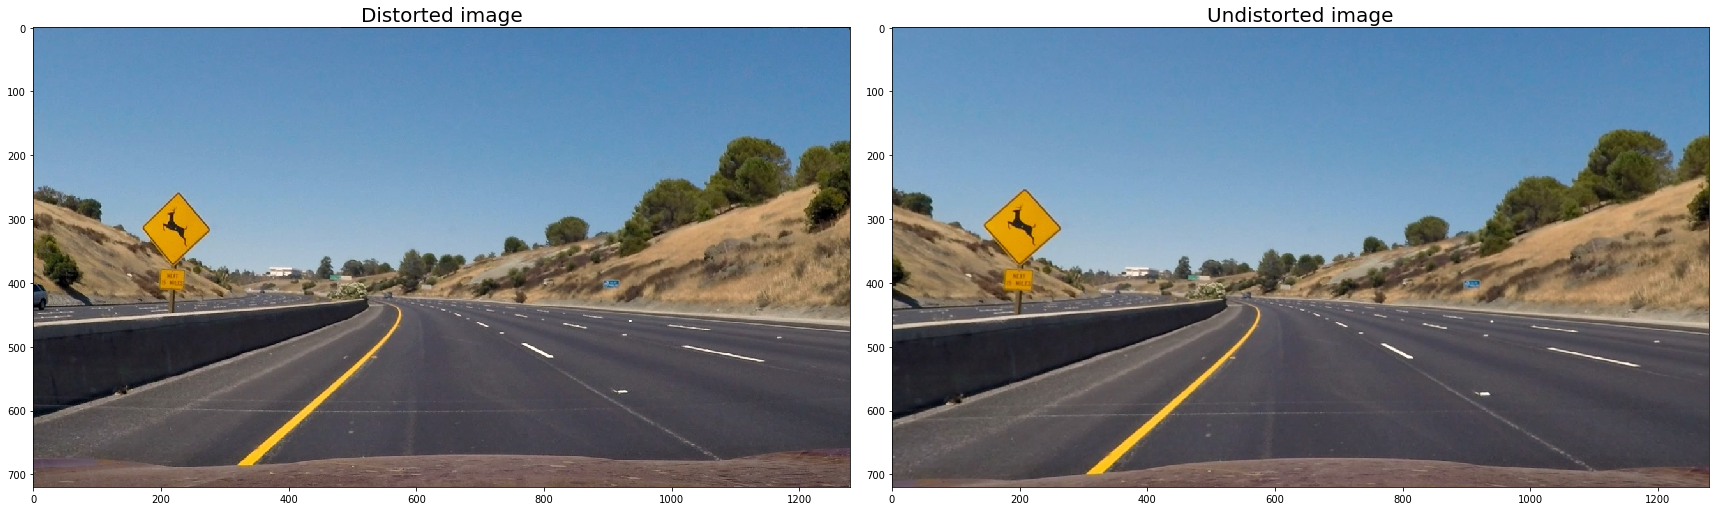

In [32]:

ret, mtx, dist, rvecs, tvecs = calibrateCamera()
img = mpimg.imread('test_images/test2.jpg')
img_undistorted = undistort(img, mtx, dist)
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(24,12))
fig.tight_layout()
ax1.imshow(img)
ax1.set_title('Distorted image', fontsize=20)
ax2.imshow(img_undistorted)
ax2.set_title('Undistorted image',fontsize=20)
#plt.savefig("test_images/test2_transformed.jpg")
plt.show()


## 2. Image preprocessing, thresholding and binarisation

In [33]:
def equializeThreshGray(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    eq_gray = cv2.equalizeHist(gray)
    _, thimg = cv2.threshold(eq_gray, thresh=250, maxval= 255, type=cv2.THRESH_BINARY)
    return thimg


def sobelImg(img, thresh_min = 25, thresh_max = 255, sobel_kernel = 11):
    grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = np.absolute(cv2.Sobel(grayImg,cv2.CV_64F,1,0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(grayImg,cv2.CV_64F,0,1, ksize=sobel_kernel))
    scaled_sobelx = np.uint16(255*sobelx/np.max(sobelx))
    scaled_sobely = np.uint16(255*sobely/np.max(sobely))
    sobel_sum = scaled_sobelx+0.2*scaled_sobely
    scaled_sobel_sum = np.uint8(255*sobel_sum/np.max(sobel_sum))
    sum_binary = np.zeros_like(scaled_sobel_sum)
    sum_binary[(scaled_sobel_sum >= thresh_min) & (scaled_sobel_sum <= thresh_max)] = 1
    return sum_binary

def sobelMagnitude(img, thresh_min=75, thresh_max=255, sobel_kernel=11):
    grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = np.absolute(cv2.Sobel(grayImg, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(grayImg, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scaled_gradmag = np.uint8(255*gradmag/np.max(gradmag))
    gradmag_binary = np.zeros_like(scaled_gradmag)
    gradmag_binary[(scaled_gradmag >= thresh_min) & (scaled_gradmag <= thresh_max)] = 1
    return gradmag_binary


def hsvThres(img, thresh_min , thresh_max ):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask_gt = np.all(hls>thresh_min, axis=2)
    mask_lt = np.all(hls<thresh_max, axis=2)
    hsv_mask = np.logical_and(mask_gt, mask_lt)
    return hsv_mask



#Now make the main image processing pipeline


def binariseImage(img, displayImages=False):
    h, w, c = img.shape
    hls_min, hls_max = ([0,70,70], [50, 255, 255])



    binary_mask = np.zeros((h, w), dtype = np.uint8)
    # First detect yellow lines
    s_mask = hsvThres(img, hls_min,hls_max)

    binary_mask = np.logical_or(binary_mask,s_mask)


    # now detect white lines by thresholding equialised frame

    white_mask = equializeThreshGray(img)
    binary_mask = np.logical_or(binary_mask, white_mask)

    # get sobel max
    sob_min, sob_max = 75, 255
    # Now do a red channel thresholding
    sob_mask = sobelMagnitude(img, thresh_min=75, thresh_max=255, sobel_kernel=9)
    binary_mask = np.logical_or(binary_mask, sob_mask)


    # Now do a simple dilate then erode to fill holes, to keep lines continuous
    kernel = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(binary_mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)

    print("closing type = %s" %str(closing.dtype))
    if displayImages==True:
        fig, ax = plt.subplots(2, 3,figsize=(15,6))
        fig.tight_layout()
        ax[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        ax[0, 0].set_title('input_frame')

        ax[0, 0].set_axis_bgcolor('red')
        ax[0, 1].imshow(white_mask, cmap='gray')


        ax[0, 2].imshow(s_mask, cmap='gray')
        ax[0, 2].set_title('yellow mask')


        ax[1, 0].imshow(sob_mask, cmap='gray')
        ax[1, 0].set_title('sobel mask')


        ax[1, 1].imshow(binary_mask, cmap='gray')
        ax[1, 1].set_title('Final Binary mask')


        ax[1, 2].imshow(closing, cmap='gray')
        ax[1, 2].set_title('after filling')
        #plt.savefig("test_images/test2_bin.jpg")
        plt.show()
    return closing





## Testing the edge detection pipeline


closing type = uint8


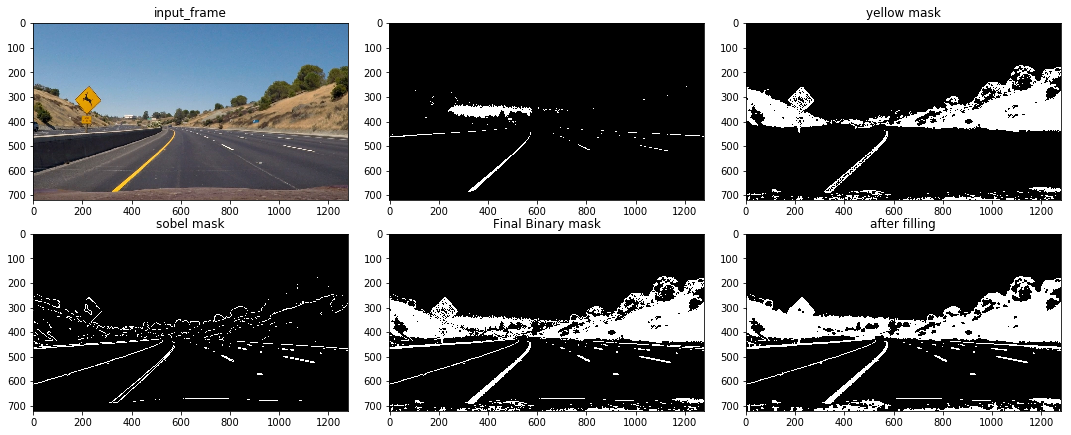

In [34]:
test_images = glob.glob('test_images/*.jpg')

img = cv2.imread("test_images/test2.jpg")
closed = binariseImage(img, True)


# Perspective Transform


closing type = uint8


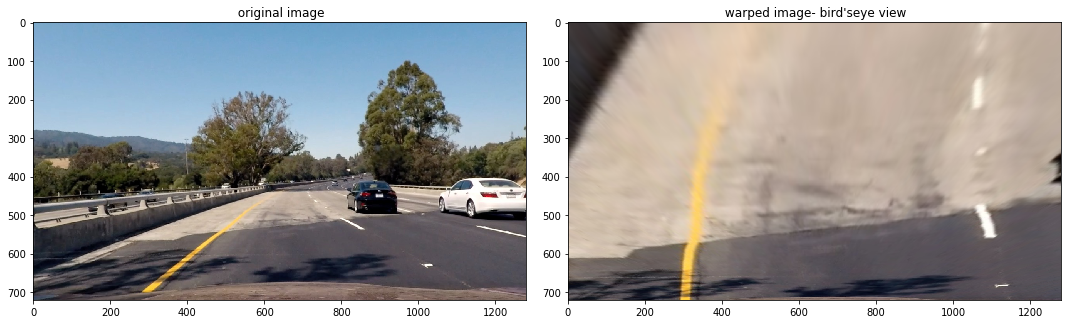

(720, 1280)


In [35]:
def perspectiveTransform(img, displayImages=False, showQuad=True):
    h,w = img.shape[:2]
    src_pts = np.float32([[0, h-30],[w,h-30],[540,450],[750,450]])
    dst_pts = np.float32([[0,h],[w,h],[0,0],[w,0]])
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    Minv = cv2.getPerspectiveTransform(dst_pts,src_pts)
    warped_img = cv2.warpPerspective(img, M, (w,h), flags = cv2.INTER_LINEAR)


    if displayImages==True:
        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,9))
        fig.tight_layout()
        ax1.imshow(img, cmap='gray')
        ax1.set_title(" original image")
        ax2.imshow(warped_img, cmap='gray')
        ax2.set_title(" warped image- bird'seye view")
        #plt.savefig('test4_persp.jpg')
        plt.show()
    return warped_img, M, Minv

# show result on test images
# for test_img in glob.glob('test_images/*.jpg'):

test_img = "test_images/test4.jpg"
img = mpimg.imread(test_img)
img_undistorted = undistort(img, mtx, dist)
img_binary = binariseImage(img_undistorted,displayImages=False)
img_birdeye, M, Minv = perspectiveTransform(img_undistorted, True)
print(img_binary.shape)



## Now do the sliding window fitting part

In [36]:
ym_per_pix = 30 / 720   # meters per pixel in y dimension
xm_per_pix = 3.7 / 700  # meters per pixel in x dimension
time_window = 15        # results are averaged over this number of frames

In [37]:
def sliding_window_polyfit(birdeye_binary, line_lt, line_rt, n_windows=9, print_image=False):
    height, width = birdeye_binary.shape

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(birdeye_binary[height//2:-30, :], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((birdeye_binary, birdeye_binary, birdeye_binary)) * 255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = len(histogram) // 2
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(height / n_windows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = birdeye_binary.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    margin = 100  # width of the windows +/- margin
    minpix = 50   # minimum number of pixels found to recenter window

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(n_windows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = height - (window + 1) * window_height
        win_y_high = height - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_xleft_low)
                          & (nonzero_x < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_xright_low)
                           & (nonzero_x < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzero_x[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzero_x[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    line_lt.allx, line_lt.ally = nonzero_x[left_lane_inds], nonzero_y[left_lane_inds]
    line_rt.allx, line_rt.ally = nonzero_x[right_lane_inds], nonzero_y[right_lane_inds]

    detected = True
    if not list(line_lt.allx) or not list(line_lt.ally):
        left_fit_pixel = line_lt.lastFitPixel
        left_fit_meter = line_lt.lastFitMeter
        detected = False
    else:
        left_fit_pixel = np.polyfit(line_lt.ally, line_lt.allx, 2)
        left_fit_meter = np.polyfit(line_lt.ally * ym_per_pix, line_lt.allx * xm_per_pix, 2)

    if not list(line_rt.allx) or not list(line_rt.ally):
        right_fit_pixel = line_rt.lastFitPixel
        right_fit_meter = line_rt.lastFitMeter
        detected = False
    else:
        right_fit_pixel = np.polyfit(line_rt.ally, line_rt.allx, 2)
        right_fit_meter = np.polyfit(line_rt.ally * ym_per_pix, line_rt.allx * xm_per_pix, 2)

    line_lt.update_line_eq(left_fit_pixel, left_fit_meter, detected=detected)
    line_rt.update_line_eq(right_fit_pixel, right_fit_meter, detected=detected)

    # Generate x and y values for plotting
    ploty = np.linspace(0, height - 1, height)
    left_fitx = left_fit_pixel[0] * ploty ** 2 + left_fit_pixel[1] * ploty + left_fit_pixel[2]
    right_fitx = right_fit_pixel[0] * ploty ** 2 + right_fit_pixel[1] * ploty + right_fit_pixel[2]

    out_img[nonzero_y[left_lane_inds], nonzero_x[left_lane_inds]] = [255, 0, 0]
    out_img[nonzero_y[right_lane_inds], nonzero_x[right_lane_inds]] = [0, 0, 255]

    if print_image:
        f, ax = plt.subplots(1, 2, figsize=(15,6),  subplot_kw={'xticks': [], 'yticks': []})
        f.set_facecolor('white')
        ax[0].imshow(birdeye_binary, cmap='gray')
        ax[1].imshow(out_img)
        ax[1].plot(left_fitx, ploty, color='yellow')
        ax[1].plot(right_fitx, ploty, color='yellow')
        ax[1].set_xlim(0, 1280)
        ax[1].set_ylim(720, 0)
        #plt.savefig("test_images/sliding.jpg")
        plt.show()
    return line_lt, line_rt, out_img

In [38]:
def approx_by_previous_fits(birdeye_binary, line_lt, line_rt, print_image=False):
    """
    This function uses previously detected lane-lines to
    search of lane-lines in the current frame.
    """

    height, width = birdeye_binary.shape

    left_fit_pixel = line_lt.lastFitPixel
    right_fit_pixel = line_rt.lastFitPixel

    nonzero = birdeye_binary.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    margin = 100
    left_lane_inds = (
    (nonzero_x > (left_fit_pixel[0] * (nonzero_y ** 2) + left_fit_pixel[1] * nonzero_y + left_fit_pixel[2] - margin)) & (
    nonzero_x < (left_fit_pixel[0] * (nonzero_y ** 2) + left_fit_pixel[1] * nonzero_y + left_fit_pixel[2] + margin)))
    right_lane_inds = (
    (nonzero_x > (right_fit_pixel[0] * (nonzero_y ** 2) + right_fit_pixel[1] * nonzero_y + right_fit_pixel[2] - margin)) & (
    nonzero_x < (right_fit_pixel[0] * (nonzero_y ** 2) + right_fit_pixel[1] * nonzero_y + right_fit_pixel[2] + margin)))

    # Extract left and right line pixel positions
    line_lt.allx, line_lt.ally = nonzero_x[left_lane_inds], nonzero_y[left_lane_inds]
    line_rt.allx, line_rt.ally = nonzero_x[right_lane_inds], nonzero_y[right_lane_inds]

    detected = True
    if not list(line_lt.allx) or not list(line_lt.ally):
        left_fit_pixel = line_lt.lastFitPixel
        left_fit_meter = line_lt.lastFitMeter
        detected = False
    else:
        left_fit_pixel = np.polyfit(line_lt.ally, line_lt.allx, 2)
        left_fit_meter = np.polyfit(line_lt.ally * ym_per_pix, line_lt.allx * xm_per_pix, 2)

    if not list(line_rt.allx) or not list(line_rt.ally):
        right_fit_pixel = line_rt.lastFitPixel
        right_fit_meter = line_rt.lastFitMeter
        detected = False
    else:
        right_fit_pixel = np.polyfit(line_rt.ally, line_rt.allx, 2)
        right_fit_meter = np.polyfit(line_rt.ally * ym_per_pix, line_rt.allx * xm_per_pix, 2)

    line_lt.update_line_eq(left_fit_pixel, left_fit_meter, detected=detected)
    line_rt.update_line_eq(right_fit_pixel, right_fit_meter, detected=detected)

    # Generate x and y values for plotting
    ploty = np.linspace(0, height - 1, height)
    left_fitx = left_fit_pixel[0] * ploty ** 2 + left_fit_pixel[1] * ploty + left_fit_pixel[2]
    right_fitx = right_fit_pixel[0] * ploty ** 2 + right_fit_pixel[1] * ploty + right_fit_pixel[2]

    # Create an image to draw on and an image to show the selection window
    img_fit = np.dstack((birdeye_binary, birdeye_binary, birdeye_binary)) * 255
    window_img = np.zeros_like(img_fit)

    # Color in left and right line pixels
    img_fit[nonzero_y[left_lane_inds], nonzero_x[left_lane_inds]] = [255, 0, 0]
    img_fit[nonzero_y[right_lane_inds], nonzero_x[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
    result = cv2.addWeighted(img_fit, 1, window_img, 0.3, 0)

    if print_image:
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

        plt.show()

    return line_lt, line_rt, img_fit

In [39]:
def combine_line_with_road(img_undistorted, Minv, line_lt, line_rt, keep_state):
    """
    Draw both the drivable lane area and the detected lane-lines 
    onto the original (undistorted) frame.
    """
    height, width, _ = img_undistorted.shape

    left_fit = line_lt.average_fit if keep_state else line_lt.lastFitPixel
    right_fit = line_rt.average_fit if keep_state else line_rt.lastFitPixel

    # Generate x and y values for plotting
    ploty = np.linspace(0, height - 1, height)
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    # draw road as green polygon on original frame
    road_warp = np.zeros_like(img_undistorted, dtype=np.uint8)
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(road_warp, np.int_([pts]), (0, 255, 0))
    road_dewarped = cv2.warpPerspective(road_warp, Minv, (width, height))  # Warp back to original image space

    combine_road = cv2.addWeighted(img_undistorted, 1., road_dewarped, 0.3, 0)

    # now separately draw solid lines to highlight them
    line_warp = np.zeros_like(img_undistorted)
    line_warp = line_lt.draw(line_warp, color=(255, 0, 0), average=keep_state)
    line_warp = line_rt.draw(line_warp, color=(255, 0, 0), average=keep_state)
    line_dewarped = cv2.warpPerspective(line_warp, Minv, (width, height))

    lines_mask = combine_road.copy()
    idx = np.any([line_dewarped != 0][0], axis=2)
    lines_mask[idx] = line_dewarped[idx]

    combine_road = cv2.addWeighted(src1=lines_mask, alpha=0.8, src2=combine_road, beta=0.5, gamma=0.)

    return combine_road

In [40]:
import collections
class Line:
    def __init__(self, buflen=15):

        # flag to mark if the line was detected the last iteration
        self.detected = False

        # polynomial coefficients fitted on the last iteration
        self.lastFitPixel = None
        self.lastFitMeter = None

        # list of polynomial coefficients of the last N iterations
        self.recentFitsPixel = collections.deque(maxlen=buflen)
        self.recentFitsMeter = collections.deque(maxlen=2 * buflen)

        self.radius_of_curvature = None

        # store all pixels coords (x, y) of line detected
        self.allx = None
        self.ally = None

    def update_line_eq(self, new_fit_pixel, new_fit_meter, detected, clear_buffer=False):
        """
        Update Line with new fitted coefficients.
        :param new_fit_pixel: new polynomial coefficients (pixel)
        :param new_fit_meter: new polynomial coefficients (meter)
        :param detected: if the Line was detected or inferred
        :param clear_buffer: if True, reset state
        :return: None
        """
        self.detected = detected

        if clear_buffer:
            self.recentFitsPixel.clear()
            self.recentFitsMeter.clear()

        self.lastFitPixel = new_fit_pixel
        self.lastFitMeter = new_fit_meter

        self.recentFitsPixel.append(self.lastFitPixel)
        self.recentFitsMeter.append(self.lastFitMeter)

    def draw(self, mask, color=(255, 0, 0), line_width=50, average=False):
        """
        Draw the line on a color mask image.
        """
        h, w, c = mask.shape

        plot_y = np.linspace(0, h - 1, h)
        coeffs = self.average_fit if average else self.lastFitPixel

        line_center = coeffs[0] * plot_y ** 2 + coeffs[1] * plot_y + coeffs[2]
        line_left_side = line_center - line_width // 2
        line_right_side = line_center + line_width // 2

        # Some magic here to recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array(list(zip(line_left_side, plot_y)))
        pts_right = np.array(np.flipud(list(zip(line_right_side, plot_y))))
        pts = np.vstack([pts_left, pts_right])

        # Draw the lane onto the warped blank image
        return cv2.fillPoly(mask, [np.int32(pts)], color)

    @property
    # average of polynomial coefficients of the last N iterations
    def average_fit(self):
        return np.mean(self.recentFitsPixel, axis=0)

    @property
    # radius of curvature of the line (averaged)
    def curvature(self):
        y_eval = 0
        coeffs = self.average_fit
        return ((1 + (2 * coeffs[0] * y_eval + coeffs[1]) ** 2) ** 1.5) / np.absolute(2 * coeffs[0])

    @property
    # radius of curvature of the line (averaged)
    def curvature_meter(self):
        y_eval = 0
        coeffs = np.mean(self.recentFitsMeter, axis=0)
        return ((1 + (2 * coeffs[0] * y_eval + coeffs[1]) ** 2) ** 1.5) / np.absolute(2 * coeffs[0])

closing type = uint8


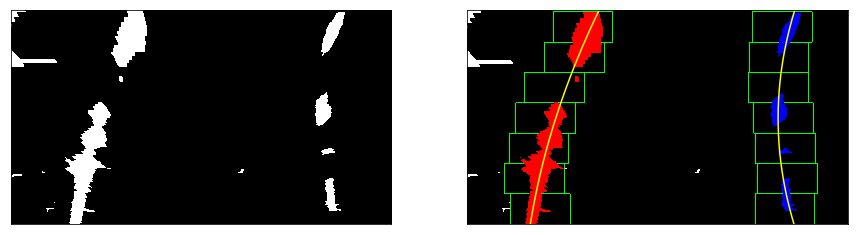

In [41]:
line_lt, line_rt = Line(buffer_len=10), Line(buffer_len=10)
img = cv2.imread("test_images/test5.jpg")
img_undistorted = undistort(img, mtx, dist)
img_binary = binariseImage(img_undistorted)
img_birdeye, M, Minv = perspectiveTransform(img_binary)
line_lt, line_rt, img_out = sliding_window_polyfit(img_birdeye, line_lt, line_rt, n_windows=7, print_image=True)


In [42]:
def add_metrics_to_img(average_fit, img_binary, img_birdeye, img_fit, line_lt, line_rt, offset_meter):
    """
   Print the final image with radius of curvature.
    """
    h, w = blend_on_road.shape[:2]

    thumb_ratio = 0.2
    thumb_h, thumb_w = int(thumb_ratio * h), int(thumb_ratio * w)

    off_x, off_y = 20, 15

    # add a gray rectangle to highlight the upper area
    mask = blend_on_road.copy()
    mask = cv2.rectangle(mask, pt1=(0, 0), pt2=(500, thumb_h+2*off_y), color=(0, 0, 0), thickness=cv2.FILLED)
    blend_on_road = cv2.addWeighted(src1=mask, alpha=0.2, src2=blend_on_road, beta=0.8, gamma=0)

    # add text (curvature and offset info) on the upper right of the blend
    mean_curvature_meter = np.mean([line_lt.curvature_meter, line_rt.curvature_meter])
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(blend_on_road, 'Radius of curvature: {:.02f}m'.format(mean_curvature_meter), (30, 60), font, 0.9, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(blend_on_road, 'Offset from center: {:.02f}m'.format(offset_meter), (30, 130), font, 0.9, (255, 255, 255), 2, cv2.LINE_AA)

    return blend_on_road

In [43]:
def compute_offset_from_center(line_lt, line_rt, frame_width):
    """
    Compute offset from center of the inferred lane.
    The offset from the lane center can be computed under the hypothesis that the camera is fixed
    and mounted in the midpoint of the car roof. In this case, we can approximate the car's deviation
    from the lane center as the distance between the center of the image and the midpoint at the bottom
    of the image of the two lane-lines detected.
    """
    if line_lt.detected and line_rt.detected:
        line_lt_bottom = np.mean(line_lt.allx[line_lt.ally > 0.95 * line_lt.ally.max()])
        line_rt_bottom = np.mean(line_rt.allx[line_rt.ally > 0.95 * line_rt.ally.max()])
        lane_width = line_rt_bottom - line_lt_bottom
        midpoint = frame_width / 2
        offset_pix = abs((line_lt_bottom + lane_width / 2) - midpoint)
        offset_meter = xm_per_pix * offset_pix
    else:
        offset_meter = -1

    return offset_meter

In [44]:
def process_pipeline(frame, keep_state=True):
    """
    Apply whole lane detection pipeline to an input color frame.
    """

    global line_lt, line_rt, processed_frames

    # undistort the image using coefficients found in calibration
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    img_undistorted = undistort(frame, mtx, dist)

    # binarize the frame s.t. lane lines are highlighted as much as possible
    img_binary = binariseImage(img_undistorted)

    # compute perspective transform to obtain bird's eye view
    img_birdeye, M, Minv = perspectiveTransform(img_binary)

    # fit 2-degree polynomial curve onto lane lines found
    if processed_frames > 0 and keep_state and line_lt.detected and line_rt.detected:
        line_lt, line_rt, img_fit = approx_by_previous_fits(img_birdeye, line_lt, line_rt)
    else:
        line_lt, line_rt, img_fit = sliding_window_polyfit(img_birdeye, line_lt, line_rt, n_windows=11)

    # compute offset in meter from center of the lane
    offset_meter = compute_offset_from_center(line_lt, line_rt, frame_width=frame.shape[1])

    # draw the surface enclosed by lane lines back onto the original frame
    blend_on_road = combine_line_with_road(img_undistorted, Minv, line_lt, line_rt, keep_state)

    # stitch on the top of final output images from different steps of the pipeline
    blend_output = add_metrics_to_img(blend_on_road, img_binary, img_birdeye, img_fit, line_lt, line_rt, offset_meter)

    processed_frames += 1

    return cv2.cvtColor(blend_output, cv2.COLOR_BGR2RGB)

In [45]:
processed_frames = 0
frame = cv2.imread("test_images/test3.jpg")
blend = process_pipeline(frame, keep_state=False)

closing type = uint8


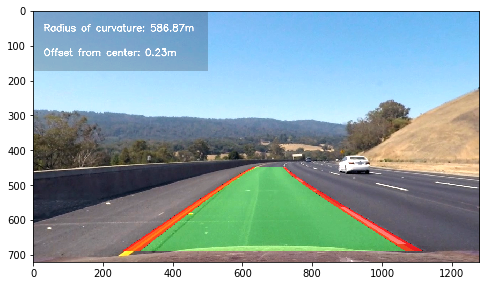

In [46]:
plt.figure(figsize=(8,8))
plt.grid('off')
plt.imshow(cv2.cvtColor(blend, code=cv2.COLOR_BGR2RGB))
#plt.savefig("test_images/road_detected.jpg")
plt.show()


In [22]:
from moviepy.editor import VideoFileClip


In [23]:
line_lt, line_rt = Line(buflen=10), Line(buflen=10)
processed_frames = 0
clip = VideoFileClip('project_video.mp4').fl_image(process_pipeline)
clip.write_videofile('project_video_out.mp4', audio=False)

closing type = uint8
[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

closing type = uint8


  0%|          | 2/1261 [00:00<04:58,  4.22it/s]

closing type = uint8


  0%|          | 3/1261 [00:00<04:57,  4.23it/s]

closing type = uint8


  0%|          | 4/1261 [00:00<04:53,  4.28it/s]

closing type = uint8


  0%|          | 5/1261 [00:01<04:55,  4.24it/s]

closing type = uint8


  0%|          | 6/1261 [00:01<04:53,  4.28it/s]

closing type = uint8


  1%|          | 7/1261 [00:01<04:57,  4.22it/s]

closing type = uint8


  1%|          | 8/1261 [00:01<04:57,  4.21it/s]

closing type = uint8


  1%|          | 9/1261 [00:02<04:55,  4.24it/s]

closing type = uint8


  1%|          | 10/1261 [00:02<04:51,  4.29it/s]

closing type = uint8


  1%|          | 11/1261 [00:02<04:51,  4.29it/s]

closing type = uint8


  1%|          | 12/1261 [00:02<04:57,  4.20it/s]

closing type = uint8


  1%|          | 13/1261 [00:03<04:54,  4.23it/s]

closing type = uint8


  1%|          | 14/1261 [00:03<04:53,  4.24it/s]

closing type = uint8


  1%|          | 15/1261 [00:03<04:50,  4.30it/s]

closing type = uint8


  1%|▏         | 16/1261 [00:03<04:48,  4.31it/s]

closing type = uint8


  1%|▏         | 17/1261 [00:04<05:01,  4.13it/s]

closing type = uint8


  1%|▏         | 18/1261 [00:04<05:47,  3.58it/s]

closing type = uint8


  2%|▏         | 19/1261 [00:04<05:27,  3.79it/s]

closing type = uint8


  2%|▏         | 20/1261 [00:04<05:14,  3.94it/s]

closing type = uint8


  2%|▏         | 21/1261 [00:05<05:06,  4.04it/s]

closing type = uint8


  2%|▏         | 22/1261 [00:05<05:02,  4.10it/s]

closing type = uint8


  2%|▏         | 23/1261 [00:05<04:56,  4.18it/s]

closing type = uint8


  2%|▏         | 24/1261 [00:05<04:54,  4.20it/s]

closing type = uint8


  2%|▏         | 25/1261 [00:06<05:07,  4.03it/s]

closing type = uint8


  2%|▏         | 26/1261 [00:06<05:03,  4.08it/s]

closing type = uint8


  2%|▏         | 27/1261 [00:06<04:58,  4.14it/s]

closing type = uint8


  2%|▏         | 28/1261 [00:06<04:55,  4.17it/s]

closing type = uint8


  2%|▏         | 29/1261 [00:06<04:56,  4.16it/s]

closing type = uint8


  2%|▏         | 30/1261 [00:07<04:56,  4.16it/s]

closing type = uint8


  2%|▏         | 31/1261 [00:07<04:55,  4.16it/s]

closing type = uint8


  3%|▎         | 32/1261 [00:07<05:06,  4.01it/s]

closing type = uint8


  3%|▎         | 33/1261 [00:08<05:14,  3.90it/s]

closing type = uint8


  3%|▎         | 34/1261 [00:08<05:05,  4.01it/s]

closing type = uint8


  3%|▎         | 35/1261 [00:08<04:59,  4.10it/s]

closing type = uint8


  3%|▎         | 36/1261 [00:08<04:53,  4.18it/s]

closing type = uint8


  3%|▎         | 37/1261 [00:08<04:51,  4.20it/s]

closing type = uint8


  3%|▎         | 38/1261 [00:09<04:50,  4.21it/s]

closing type = uint8


  3%|▎         | 39/1261 [00:09<05:49,  3.49it/s]

closing type = uint8


  3%|▎         | 40/1261 [00:09<05:39,  3.60it/s]

closing type = uint8


  3%|▎         | 41/1261 [00:10<06:05,  3.34it/s]

closing type = uint8


  3%|▎         | 42/1261 [00:10<06:05,  3.33it/s]

closing type = uint8


  3%|▎         | 43/1261 [00:10<05:51,  3.46it/s]

closing type = uint8


  3%|▎         | 44/1261 [00:11<05:41,  3.56it/s]

closing type = uint8


  4%|▎         | 45/1261 [00:11<05:31,  3.67it/s]

closing type = uint8


  4%|▎         | 46/1261 [00:11<05:25,  3.73it/s]

closing type = uint8


  4%|▎         | 47/1261 [00:11<05:19,  3.80it/s]

closing type = uint8


  4%|▍         | 48/1261 [00:12<05:13,  3.87it/s]

closing type = uint8


  4%|▍         | 49/1261 [00:12<05:12,  3.88it/s]

closing type = uint8


  4%|▍         | 50/1261 [00:12<05:09,  3.92it/s]

closing type = uint8


  4%|▍         | 51/1261 [00:12<05:08,  3.93it/s]

closing type = uint8


  4%|▍         | 52/1261 [00:13<05:05,  3.95it/s]

closing type = uint8


  4%|▍         | 53/1261 [00:13<05:05,  3.95it/s]

closing type = uint8


  4%|▍         | 54/1261 [00:13<05:07,  3.93it/s]

closing type = uint8


  4%|▍         | 55/1261 [00:13<05:05,  3.94it/s]

closing type = uint8


  4%|▍         | 56/1261 [00:14<05:06,  3.93it/s]

closing type = uint8


  5%|▍         | 57/1261 [00:14<05:07,  3.91it/s]

closing type = uint8


  5%|▍         | 58/1261 [00:14<05:05,  3.94it/s]

closing type = uint8


  5%|▍         | 59/1261 [00:14<05:03,  3.95it/s]

closing type = uint8


  5%|▍         | 60/1261 [00:15<05:04,  3.95it/s]

closing type = uint8


  5%|▍         | 61/1261 [00:15<05:03,  3.96it/s]

closing type = uint8


  5%|▍         | 62/1261 [00:15<05:02,  3.97it/s]

closing type = uint8


  5%|▍         | 63/1261 [00:15<05:09,  3.87it/s]

closing type = uint8


  5%|▌         | 64/1261 [00:16<06:05,  3.27it/s]

closing type = uint8


  5%|▌         | 65/1261 [00:16<05:50,  3.42it/s]

closing type = uint8


  5%|▌         | 66/1261 [00:16<05:43,  3.48it/s]

closing type = uint8


  5%|▌         | 67/1261 [00:17<05:41,  3.49it/s]

closing type = uint8


  5%|▌         | 68/1261 [00:17<05:34,  3.56it/s]

closing type = uint8


  5%|▌         | 69/1261 [00:17<05:29,  3.62it/s]

closing type = uint8


  6%|▌         | 70/1261 [00:17<05:17,  3.75it/s]

closing type = uint8


  6%|▌         | 71/1261 [00:18<05:13,  3.80it/s]

closing type = uint8


  6%|▌         | 72/1261 [00:18<05:41,  3.48it/s]

closing type = uint8


  6%|▌         | 73/1261 [00:18<05:54,  3.35it/s]

closing type = uint8


  6%|▌         | 74/1261 [00:19<05:34,  3.55it/s]

closing type = uint8


  6%|▌         | 75/1261 [00:19<05:29,  3.60it/s]

closing type = uint8


  6%|▌         | 76/1261 [00:19<05:18,  3.72it/s]

closing type = uint8


  6%|▌         | 77/1261 [00:19<05:15,  3.75it/s]

closing type = uint8


  6%|▌         | 78/1261 [00:20<05:16,  3.74it/s]

closing type = uint8


  6%|▋         | 79/1261 [00:20<05:17,  3.72it/s]

closing type = uint8


  6%|▋         | 80/1261 [00:20<05:10,  3.81it/s]

closing type = uint8


  6%|▋         | 81/1261 [00:20<05:03,  3.89it/s]

closing type = uint8


  7%|▋         | 82/1261 [00:21<05:01,  3.91it/s]

closing type = uint8


  7%|▋         | 83/1261 [00:21<04:56,  3.97it/s]

closing type = uint8


  7%|▋         | 84/1261 [00:21<04:57,  3.96it/s]

closing type = uint8


  7%|▋         | 85/1261 [00:21<04:57,  3.96it/s]

closing type = uint8


  7%|▋         | 86/1261 [00:22<04:56,  3.97it/s]

closing type = uint8


  7%|▋         | 87/1261 [00:22<04:55,  3.98it/s]

closing type = uint8


  7%|▋         | 88/1261 [00:22<04:54,  3.98it/s]

closing type = uint8


  7%|▋         | 89/1261 [00:22<04:51,  4.02it/s]

closing type = uint8


  7%|▋         | 90/1261 [00:23<04:52,  4.00it/s]

closing type = uint8


  7%|▋         | 91/1261 [00:23<04:54,  3.97it/s]

closing type = uint8


  7%|▋         | 92/1261 [00:23<04:53,  3.98it/s]

closing type = uint8


  7%|▋         | 93/1261 [00:23<04:49,  4.03it/s]

closing type = uint8


  7%|▋         | 94/1261 [00:24<04:53,  3.98it/s]

closing type = uint8


  8%|▊         | 95/1261 [00:24<04:54,  3.95it/s]

closing type = uint8


  8%|▊         | 96/1261 [00:24<05:33,  3.49it/s]

closing type = uint8


  8%|▊         | 97/1261 [00:25<05:41,  3.41it/s]

closing type = uint8


  8%|▊         | 98/1261 [00:25<05:47,  3.34it/s]

closing type = uint8


  8%|▊         | 99/1261 [00:25<05:38,  3.43it/s]

closing type = uint8


  8%|▊         | 100/1261 [00:25<05:25,  3.57it/s]

closing type = uint8


  8%|▊         | 101/1261 [00:26<05:13,  3.70it/s]

closing type = uint8


  8%|▊         | 102/1261 [00:26<05:06,  3.78it/s]

closing type = uint8


  8%|▊         | 103/1261 [00:26<04:57,  3.89it/s]

closing type = uint8


  8%|▊         | 104/1261 [00:26<04:58,  3.87it/s]

closing type = uint8


  8%|▊         | 105/1261 [00:27<05:06,  3.77it/s]

closing type = uint8


  8%|▊         | 106/1261 [00:27<04:59,  3.85it/s]

closing type = uint8


  8%|▊         | 107/1261 [00:27<04:52,  3.95it/s]

closing type = uint8


  9%|▊         | 108/1261 [00:27<04:50,  3.97it/s]

closing type = uint8


  9%|▊         | 109/1261 [00:28<04:51,  3.96it/s]

closing type = uint8


  9%|▊         | 110/1261 [00:28<04:48,  3.99it/s]

closing type = uint8


  9%|▉         | 111/1261 [00:28<04:48,  3.99it/s]

closing type = uint8


  9%|▉         | 112/1261 [00:28<04:47,  4.00it/s]

closing type = uint8


  9%|▉         | 113/1261 [00:29<04:47,  3.99it/s]

closing type = uint8


  9%|▉         | 114/1261 [00:29<04:47,  3.99it/s]

closing type = uint8


  9%|▉         | 115/1261 [00:29<04:47,  3.98it/s]

closing type = uint8


  9%|▉         | 116/1261 [00:29<04:45,  4.01it/s]

closing type = uint8


  9%|▉         | 117/1261 [00:30<04:52,  3.91it/s]

closing type = uint8


  9%|▉         | 118/1261 [00:30<04:52,  3.91it/s]

closing type = uint8


  9%|▉         | 119/1261 [00:30<04:53,  3.90it/s]

closing type = uint8


 10%|▉         | 120/1261 [00:30<04:54,  3.88it/s]

closing type = uint8


 10%|▉         | 121/1261 [00:31<04:53,  3.89it/s]

closing type = uint8


 10%|▉         | 122/1261 [00:31<04:57,  3.83it/s]

closing type = uint8


 10%|▉         | 123/1261 [00:31<04:48,  3.94it/s]

closing type = uint8


 10%|▉         | 124/1261 [00:31<04:45,  3.98it/s]

closing type = uint8


 10%|▉         | 125/1261 [00:32<04:47,  3.95it/s]

closing type = uint8


 10%|▉         | 126/1261 [00:32<04:50,  3.90it/s]

closing type = uint8


 10%|█         | 127/1261 [00:32<04:48,  3.93it/s]

closing type = uint8


 10%|█         | 128/1261 [00:32<04:46,  3.95it/s]

closing type = uint8


 10%|█         | 129/1261 [00:33<04:47,  3.94it/s]

closing type = uint8


 10%|█         | 130/1261 [00:33<04:49,  3.91it/s]

closing type = uint8


 10%|█         | 131/1261 [00:33<04:46,  3.94it/s]

closing type = uint8


 10%|█         | 132/1261 [00:34<05:18,  3.55it/s]

closing type = uint8


 11%|█         | 133/1261 [00:34<05:20,  3.52it/s]

closing type = uint8


 11%|█         | 134/1261 [00:34<05:23,  3.48it/s]

closing type = uint8


 11%|█         | 135/1261 [00:34<05:19,  3.53it/s]

closing type = uint8


 11%|█         | 136/1261 [00:35<05:13,  3.58it/s]

closing type = uint8


 11%|█         | 137/1261 [00:35<05:04,  3.70it/s]

closing type = uint8


 11%|█         | 138/1261 [00:35<04:55,  3.80it/s]

closing type = uint8


 11%|█         | 139/1261 [00:35<04:50,  3.86it/s]

closing type = uint8


 11%|█         | 140/1261 [00:36<04:45,  3.93it/s]

closing type = uint8


 11%|█         | 141/1261 [00:36<04:42,  3.96it/s]

closing type = uint8


 11%|█▏        | 142/1261 [00:36<04:42,  3.97it/s]

closing type = uint8


 11%|█▏        | 143/1261 [00:36<04:41,  3.97it/s]

closing type = uint8


 11%|█▏        | 144/1261 [00:37<04:38,  4.02it/s]

closing type = uint8


 11%|█▏        | 145/1261 [00:37<04:37,  4.03it/s]

closing type = uint8


 12%|█▏        | 146/1261 [00:37<04:36,  4.03it/s]

closing type = uint8


 12%|█▏        | 147/1261 [00:37<04:37,  4.02it/s]

closing type = uint8


 12%|█▏        | 148/1261 [00:38<04:39,  3.98it/s]

closing type = uint8
closing type = uint8


 12%|█▏        | 150/1261 [00:38<05:15,  3.52it/s]

closing type = uint8


 12%|█▏        | 151/1261 [00:39<05:47,  3.19it/s]

closing type = uint8


 12%|█▏        | 152/1261 [00:39<05:30,  3.36it/s]

closing type = uint8


 12%|█▏        | 153/1261 [00:39<05:15,  3.51it/s]

closing type = uint8


 12%|█▏        | 154/1261 [00:39<05:05,  3.62it/s]

closing type = uint8


 12%|█▏        | 155/1261 [00:40<05:40,  3.25it/s]

closing type = uint8


 12%|█▏        | 156/1261 [00:40<05:28,  3.36it/s]

closing type = uint8


 12%|█▏        | 157/1261 [00:40<05:11,  3.55it/s]

closing type = uint8
closing type = uint8


 13%|█▎        | 159/1261 [00:41<05:40,  3.23it/s]

closing type = uint8


 13%|█▎        | 160/1261 [00:41<05:24,  3.39it/s]

closing type = uint8


 13%|█▎        | 161/1261 [00:42<05:14,  3.50it/s]

closing type = uint8


 13%|█▎        | 162/1261 [00:42<05:06,  3.59it/s]

closing type = uint8


 13%|█▎        | 163/1261 [00:42<04:54,  3.72it/s]

closing type = uint8


 13%|█▎        | 164/1261 [00:42<04:51,  3.77it/s]

closing type = uint8


 13%|█▎        | 165/1261 [00:43<04:46,  3.83it/s]

closing type = uint8


 13%|█▎        | 166/1261 [00:43<04:38,  3.93it/s]

closing type = uint8


 13%|█▎        | 167/1261 [00:43<04:35,  3.98it/s]

closing type = uint8


 13%|█▎        | 168/1261 [00:43<04:33,  4.00it/s]

closing type = uint8


 13%|█▎        | 169/1261 [00:44<04:31,  4.02it/s]

closing type = uint8


 13%|█▎        | 170/1261 [00:44<04:38,  3.91it/s]

closing type = uint8


 14%|█▎        | 171/1261 [00:44<04:38,  3.91it/s]

closing type = uint8


 14%|█▎        | 172/1261 [00:44<04:33,  3.98it/s]

closing type = uint8


 14%|█▎        | 173/1261 [00:45<04:33,  3.97it/s]

closing type = uint8


 14%|█▍        | 174/1261 [00:45<04:31,  4.00it/s]

closing type = uint8


 14%|█▍        | 175/1261 [00:45<04:33,  3.97it/s]

closing type = uint8


 14%|█▍        | 176/1261 [00:45<04:33,  3.97it/s]

closing type = uint8


 14%|█▍        | 177/1261 [00:46<04:35,  3.93it/s]

closing type = uint8


 14%|█▍        | 178/1261 [00:46<04:34,  3.95it/s]

closing type = uint8


 14%|█▍        | 179/1261 [00:46<04:35,  3.92it/s]

closing type = uint8


 14%|█▍        | 180/1261 [00:46<04:36,  3.91it/s]

closing type = uint8


 14%|█▍        | 181/1261 [00:47<04:32,  3.96it/s]

closing type = uint8


 14%|█▍        | 182/1261 [00:47<04:29,  4.00it/s]

closing type = uint8


 15%|█▍        | 183/1261 [00:47<04:59,  3.60it/s]

closing type = uint8


 15%|█▍        | 184/1261 [00:47<04:48,  3.73it/s]

closing type = uint8


 15%|█▍        | 185/1261 [00:48<04:42,  3.80it/s]

closing type = uint8


 15%|█▍        | 186/1261 [00:48<04:40,  3.83it/s]

closing type = uint8


 15%|█▍        | 187/1261 [00:48<04:41,  3.82it/s]

closing type = uint8


 15%|█▍        | 188/1261 [00:48<04:40,  3.82it/s]

closing type = uint8


 15%|█▍        | 189/1261 [00:49<04:59,  3.58it/s]

closing type = uint8


 15%|█▌        | 190/1261 [00:49<05:10,  3.44it/s]

closing type = uint8


 15%|█▌        | 191/1261 [00:49<04:58,  3.59it/s]

closing type = uint8


 15%|█▌        | 192/1261 [00:50<04:49,  3.70it/s]

closing type = uint8


 15%|█▌        | 193/1261 [00:50<04:39,  3.82it/s]

closing type = uint8


 15%|█▌        | 194/1261 [00:50<04:32,  3.91it/s]

closing type = uint8


 15%|█▌        | 195/1261 [00:50<05:00,  3.55it/s]

closing type = uint8


 16%|█▌        | 196/1261 [00:51<04:50,  3.67it/s]

closing type = uint8


 16%|█▌        | 197/1261 [00:51<04:42,  3.77it/s]

closing type = uint8


 16%|█▌        | 198/1261 [00:51<04:36,  3.84it/s]

closing type = uint8


 16%|█▌        | 199/1261 [00:52<05:02,  3.51it/s]

closing type = uint8


 16%|█▌        | 200/1261 [00:52<05:05,  3.47it/s]

closing type = uint8


 16%|█▌        | 201/1261 [00:52<04:50,  3.65it/s]

closing type = uint8


 16%|█▌        | 202/1261 [00:52<04:40,  3.78it/s]

closing type = uint8


 16%|█▌        | 203/1261 [00:53<04:34,  3.85it/s]

closing type = uint8


 16%|█▌        | 204/1261 [00:53<04:31,  3.90it/s]

closing type = uint8


 16%|█▋        | 205/1261 [00:53<04:29,  3.91it/s]

closing type = uint8


 16%|█▋        | 206/1261 [00:53<04:26,  3.96it/s]

closing type = uint8


 16%|█▋        | 207/1261 [00:54<04:24,  3.99it/s]

closing type = uint8


 16%|█▋        | 208/1261 [00:54<04:23,  4.00it/s]

closing type = uint8


 17%|█▋        | 209/1261 [00:54<04:23,  3.99it/s]

closing type = uint8


 17%|█▋        | 210/1261 [00:54<04:30,  3.88it/s]

closing type = uint8


 17%|█▋        | 211/1261 [00:55<04:28,  3.91it/s]

closing type = uint8


 17%|█▋        | 212/1261 [00:55<04:28,  3.91it/s]

closing type = uint8


 17%|█▋        | 213/1261 [00:55<04:23,  3.98it/s]

closing type = uint8


 17%|█▋        | 214/1261 [00:55<04:19,  4.03it/s]

closing type = uint8


 17%|█▋        | 215/1261 [00:56<04:20,  4.02it/s]

closing type = uint8


 17%|█▋        | 216/1261 [00:56<04:19,  4.03it/s]

closing type = uint8


 17%|█▋        | 217/1261 [00:56<04:19,  4.03it/s]

closing type = uint8


 17%|█▋        | 218/1261 [00:56<04:18,  4.04it/s]

closing type = uint8


 17%|█▋        | 219/1261 [00:57<04:19,  4.01it/s]

closing type = uint8


 17%|█▋        | 220/1261 [00:57<04:17,  4.05it/s]

closing type = uint8


 18%|█▊        | 221/1261 [00:57<04:15,  4.07it/s]

closing type = uint8


 18%|█▊        | 222/1261 [00:57<04:16,  4.05it/s]

closing type = uint8


 18%|█▊        | 223/1261 [00:58<04:16,  4.05it/s]

closing type = uint8


 18%|█▊        | 224/1261 [00:58<04:18,  4.01it/s]

closing type = uint8


 18%|█▊        | 225/1261 [00:58<04:23,  3.93it/s]

closing type = uint8


 18%|█▊        | 226/1261 [00:58<04:18,  4.01it/s]

closing type = uint8


 18%|█▊        | 227/1261 [00:59<04:18,  4.01it/s]

closing type = uint8


 18%|█▊        | 228/1261 [00:59<04:15,  4.04it/s]

closing type = uint8


 18%|█▊        | 229/1261 [00:59<04:14,  4.06it/s]

closing type = uint8


 18%|█▊        | 230/1261 [00:59<04:13,  4.07it/s]

closing type = uint8


 18%|█▊        | 231/1261 [01:00<04:11,  4.09it/s]

closing type = uint8


 18%|█▊        | 232/1261 [01:00<04:10,  4.10it/s]

closing type = uint8


 18%|█▊        | 233/1261 [01:00<04:11,  4.09it/s]

closing type = uint8


 19%|█▊        | 234/1261 [01:00<04:14,  4.04it/s]

closing type = uint8


 19%|█▊        | 235/1261 [01:01<04:12,  4.06it/s]

closing type = uint8


 19%|█▊        | 236/1261 [01:01<04:18,  3.97it/s]

closing type = uint8


 19%|█▉        | 237/1261 [01:01<04:22,  3.90it/s]

closing type = uint8


 19%|█▉        | 238/1261 [01:01<04:22,  3.89it/s]

closing type = uint8


 19%|█▉        | 239/1261 [01:02<04:19,  3.93it/s]

closing type = uint8


 19%|█▉        | 240/1261 [01:02<04:17,  3.97it/s]

closing type = uint8


 19%|█▉        | 241/1261 [01:02<04:16,  3.98it/s]

closing type = uint8


 19%|█▉        | 242/1261 [01:02<04:15,  3.99it/s]

closing type = uint8


 19%|█▉        | 243/1261 [01:03<04:17,  3.95it/s]

closing type = uint8


 19%|█▉        | 244/1261 [01:03<04:18,  3.94it/s]

closing type = uint8


 19%|█▉        | 245/1261 [01:03<04:12,  4.02it/s]

closing type = uint8


 20%|█▉        | 246/1261 [01:03<04:11,  4.03it/s]

closing type = uint8


 20%|█▉        | 247/1261 [01:04<04:13,  4.00it/s]

closing type = uint8


 20%|█▉        | 248/1261 [01:04<04:20,  3.88it/s]

closing type = uint8


 20%|█▉        | 249/1261 [01:04<04:21,  3.86it/s]

closing type = uint8


 20%|█▉        | 250/1261 [01:04<04:22,  3.85it/s]

closing type = uint8


 20%|█▉        | 251/1261 [01:05<04:19,  3.89it/s]

closing type = uint8


 20%|█▉        | 252/1261 [01:05<04:15,  3.95it/s]

closing type = uint8


 20%|██        | 253/1261 [01:05<04:15,  3.95it/s]

closing type = uint8


 20%|██        | 254/1261 [01:05<04:15,  3.94it/s]

closing type = uint8


 20%|██        | 255/1261 [01:06<04:12,  3.98it/s]

closing type = uint8


 20%|██        | 256/1261 [01:06<04:09,  4.03it/s]

closing type = uint8


 20%|██        | 257/1261 [01:06<04:09,  4.02it/s]

closing type = uint8


 20%|██        | 258/1261 [01:06<04:08,  4.03it/s]

closing type = uint8


 21%|██        | 259/1261 [01:07<04:10,  3.99it/s]

closing type = uint8


 21%|██        | 260/1261 [01:07<04:09,  4.01it/s]

closing type = uint8


 21%|██        | 261/1261 [01:07<04:10,  3.99it/s]

closing type = uint8


 21%|██        | 262/1261 [01:07<04:07,  4.04it/s]

closing type = uint8


 21%|██        | 263/1261 [01:08<04:06,  4.05it/s]

closing type = uint8


 21%|██        | 264/1261 [01:08<04:07,  4.03it/s]

closing type = uint8


 21%|██        | 265/1261 [01:08<04:11,  3.96it/s]

closing type = uint8


 21%|██        | 266/1261 [01:08<04:16,  3.88it/s]

closing type = uint8


 21%|██        | 267/1261 [01:09<04:18,  3.84it/s]

closing type = uint8


 21%|██▏       | 268/1261 [01:09<04:14,  3.90it/s]

closing type = uint8


 21%|██▏       | 269/1261 [01:09<04:12,  3.93it/s]

closing type = uint8


 21%|██▏       | 270/1261 [01:09<04:10,  3.95it/s]

closing type = uint8


 21%|██▏       | 271/1261 [01:10<04:09,  3.97it/s]

closing type = uint8


 22%|██▏       | 272/1261 [01:10<04:06,  4.01it/s]

closing type = uint8


 22%|██▏       | 273/1261 [01:10<04:09,  3.97it/s]

closing type = uint8


 22%|██▏       | 274/1261 [01:10<04:06,  4.00it/s]

closing type = uint8


 22%|██▏       | 275/1261 [01:11<04:04,  4.04it/s]

closing type = uint8


 22%|██▏       | 276/1261 [01:11<04:08,  3.97it/s]

closing type = uint8


 22%|██▏       | 277/1261 [01:11<04:07,  3.98it/s]

closing type = uint8


 22%|██▏       | 278/1261 [01:11<04:10,  3.92it/s]

closing type = uint8


 22%|██▏       | 279/1261 [01:12<04:08,  3.96it/s]

closing type = uint8


 22%|██▏       | 280/1261 [01:12<04:04,  4.01it/s]

closing type = uint8


 22%|██▏       | 281/1261 [01:12<04:03,  4.03it/s]

closing type = uint8


 22%|██▏       | 282/1261 [01:12<04:01,  4.06it/s]

closing type = uint8


 22%|██▏       | 283/1261 [01:13<04:03,  4.02it/s]

closing type = uint8


 23%|██▎       | 284/1261 [01:13<04:06,  3.97it/s]

closing type = uint8


 23%|██▎       | 285/1261 [01:13<04:07,  3.95it/s]

closing type = uint8


 23%|██▎       | 286/1261 [01:13<04:04,  3.99it/s]

closing type = uint8


 23%|██▎       | 287/1261 [01:14<04:03,  4.00it/s]

closing type = uint8


 23%|██▎       | 288/1261 [01:14<04:08,  3.92it/s]

closing type = uint8


 23%|██▎       | 289/1261 [01:14<04:09,  3.89it/s]

closing type = uint8


 23%|██▎       | 290/1261 [01:14<04:09,  3.89it/s]

closing type = uint8


 23%|██▎       | 291/1261 [01:15<04:17,  3.76it/s]

closing type = uint8


 23%|██▎       | 292/1261 [01:15<04:11,  3.86it/s]

closing type = uint8


 23%|██▎       | 293/1261 [01:15<04:08,  3.89it/s]

closing type = uint8


 23%|██▎       | 294/1261 [01:15<04:05,  3.93it/s]

closing type = uint8


 23%|██▎       | 295/1261 [01:16<04:04,  3.95it/s]

closing type = uint8


 23%|██▎       | 296/1261 [01:16<03:59,  4.02it/s]

closing type = uint8


 24%|██▎       | 297/1261 [01:16<03:56,  4.07it/s]

closing type = uint8


 24%|██▎       | 298/1261 [01:16<03:57,  4.05it/s]

closing type = uint8


 24%|██▎       | 299/1261 [01:17<03:57,  4.06it/s]

closing type = uint8


 24%|██▍       | 300/1261 [01:17<03:59,  4.01it/s]

closing type = uint8


 24%|██▍       | 301/1261 [01:17<03:59,  4.02it/s]

closing type = uint8


 24%|██▍       | 302/1261 [01:17<04:00,  3.99it/s]

closing type = uint8


 24%|██▍       | 303/1261 [01:18<03:59,  4.00it/s]

closing type = uint8


 24%|██▍       | 304/1261 [01:18<03:58,  4.01it/s]

closing type = uint8


 24%|██▍       | 305/1261 [01:18<03:57,  4.03it/s]

closing type = uint8


 24%|██▍       | 306/1261 [01:18<03:54,  4.08it/s]

closing type = uint8


 24%|██▍       | 307/1261 [01:19<03:54,  4.07it/s]

closing type = uint8


 24%|██▍       | 308/1261 [01:19<04:00,  3.96it/s]

closing type = uint8


 25%|██▍       | 309/1261 [01:19<03:57,  4.02it/s]

closing type = uint8


 25%|██▍       | 310/1261 [01:19<03:57,  4.00it/s]

closing type = uint8


 25%|██▍       | 311/1261 [01:20<03:54,  4.05it/s]

closing type = uint8


 25%|██▍       | 312/1261 [01:20<04:05,  3.87it/s]

closing type = uint8


 25%|██▍       | 313/1261 [01:20<04:03,  3.90it/s]

closing type = uint8


 25%|██▍       | 314/1261 [01:20<04:02,  3.91it/s]

closing type = uint8


 25%|██▍       | 315/1261 [01:21<04:05,  3.85it/s]

closing type = uint8


 25%|██▌       | 316/1261 [01:21<04:04,  3.87it/s]

closing type = uint8


 25%|██▌       | 317/1261 [01:21<04:00,  3.93it/s]

closing type = uint8


 25%|██▌       | 318/1261 [01:21<04:00,  3.92it/s]

closing type = uint8


 25%|██▌       | 319/1261 [01:22<03:56,  3.98it/s]

closing type = uint8


 25%|██▌       | 320/1261 [01:22<03:54,  4.01it/s]

closing type = uint8


 25%|██▌       | 321/1261 [01:22<03:52,  4.04it/s]

closing type = uint8


 26%|██▌       | 322/1261 [01:22<03:52,  4.03it/s]

closing type = uint8


 26%|██▌       | 323/1261 [01:23<03:54,  3.99it/s]

closing type = uint8


 26%|██▌       | 324/1261 [01:23<03:54,  4.00it/s]

closing type = uint8


 26%|██▌       | 325/1261 [01:23<03:54,  4.00it/s]

closing type = uint8


 26%|██▌       | 326/1261 [01:23<03:54,  3.99it/s]

closing type = uint8


 26%|██▌       | 327/1261 [01:24<04:02,  3.85it/s]

closing type = uint8


 26%|██▌       | 328/1261 [01:24<04:01,  3.87it/s]

closing type = uint8


 26%|██▌       | 329/1261 [01:24<04:00,  3.88it/s]

closing type = uint8


 26%|██▌       | 330/1261 [01:25<03:54,  3.96it/s]

closing type = uint8


 26%|██▌       | 331/1261 [01:25<03:55,  3.95it/s]

closing type = uint8


 26%|██▋       | 332/1261 [01:25<03:55,  3.95it/s]

closing type = uint8


 26%|██▋       | 333/1261 [01:25<03:51,  4.01it/s]

closing type = uint8


 26%|██▋       | 334/1261 [01:25<03:49,  4.05it/s]

closing type = uint8


 27%|██▋       | 335/1261 [01:26<03:50,  4.03it/s]

closing type = uint8


 27%|██▋       | 336/1261 [01:26<03:49,  4.02it/s]

closing type = uint8


 27%|██▋       | 337/1261 [01:26<03:57,  3.89it/s]

closing type = uint8


 27%|██▋       | 338/1261 [01:27<03:57,  3.89it/s]

closing type = uint8


 27%|██▋       | 339/1261 [01:27<03:57,  3.89it/s]

closing type = uint8


 27%|██▋       | 340/1261 [01:27<03:53,  3.94it/s]

closing type = uint8


 27%|██▋       | 341/1261 [01:27<03:57,  3.87it/s]

closing type = uint8


 27%|██▋       | 342/1261 [01:28<03:58,  3.85it/s]

closing type = uint8


 27%|██▋       | 343/1261 [01:28<03:58,  3.85it/s]

closing type = uint8


 27%|██▋       | 344/1261 [01:28<03:55,  3.90it/s]

closing type = uint8


 27%|██▋       | 345/1261 [01:28<03:55,  3.89it/s]

closing type = uint8


 27%|██▋       | 346/1261 [01:29<03:57,  3.86it/s]

closing type = uint8


 28%|██▊       | 347/1261 [01:29<03:59,  3.82it/s]

closing type = uint8


 28%|██▊       | 348/1261 [01:29<03:53,  3.91it/s]

closing type = uint8


 28%|██▊       | 349/1261 [01:29<03:53,  3.90it/s]

closing type = uint8


 28%|██▊       | 350/1261 [01:30<03:54,  3.89it/s]

closing type = uint8


 28%|██▊       | 351/1261 [01:30<03:56,  3.85it/s]

closing type = uint8


 28%|██▊       | 352/1261 [01:30<03:52,  3.91it/s]

closing type = uint8


 28%|██▊       | 353/1261 [01:30<03:50,  3.94it/s]

closing type = uint8


 28%|██▊       | 354/1261 [01:31<03:49,  3.96it/s]

closing type = uint8


 28%|██▊       | 355/1261 [01:31<03:48,  3.97it/s]

closing type = uint8


 28%|██▊       | 356/1261 [01:31<03:47,  3.98it/s]

closing type = uint8


 28%|██▊       | 357/1261 [01:31<03:49,  3.94it/s]

closing type = uint8


 28%|██▊       | 358/1261 [01:32<03:50,  3.92it/s]

closing type = uint8


 28%|██▊       | 359/1261 [01:32<03:48,  3.95it/s]

closing type = uint8


 29%|██▊       | 360/1261 [01:32<03:50,  3.91it/s]

closing type = uint8


 29%|██▊       | 361/1261 [01:32<03:55,  3.82it/s]

closing type = uint8


 29%|██▊       | 362/1261 [01:33<03:57,  3.78it/s]

closing type = uint8


 29%|██▉       | 363/1261 [01:33<03:53,  3.85it/s]

closing type = uint8


 29%|██▉       | 364/1261 [01:33<03:47,  3.94it/s]

closing type = uint8


 29%|██▉       | 365/1261 [01:33<03:43,  4.01it/s]

closing type = uint8


 29%|██▉       | 366/1261 [01:34<03:41,  4.04it/s]

closing type = uint8


 29%|██▉       | 367/1261 [01:34<03:39,  4.08it/s]

closing type = uint8


 29%|██▉       | 368/1261 [01:34<03:43,  4.00it/s]

closing type = uint8
closing type = uint8


 29%|██▉       | 370/1261 [01:35<04:11,  3.54it/s]

closing type = uint8


 29%|██▉       | 371/1261 [01:35<04:02,  3.67it/s]

closing type = uint8


 30%|██▉       | 372/1261 [01:35<03:55,  3.77it/s]

closing type = uint8


 30%|██▉       | 373/1261 [01:36<03:47,  3.90it/s]

closing type = uint8


 30%|██▉       | 374/1261 [01:36<03:48,  3.89it/s]

closing type = uint8


 30%|██▉       | 375/1261 [01:36<03:45,  3.93it/s]

closing type = uint8


 30%|██▉       | 376/1261 [01:36<03:43,  3.95it/s]

closing type = uint8


 30%|██▉       | 377/1261 [01:37<03:41,  3.99it/s]

closing type = uint8


 30%|██▉       | 378/1261 [01:37<03:40,  4.00it/s]

closing type = uint8


 30%|███       | 379/1261 [01:37<03:38,  4.05it/s]

closing type = uint8


 30%|███       | 380/1261 [01:37<03:38,  4.03it/s]

closing type = uint8


 30%|███       | 381/1261 [01:38<03:37,  4.05it/s]

closing type = uint8


 30%|███       | 382/1261 [01:38<03:38,  4.02it/s]

closing type = uint8


 30%|███       | 383/1261 [01:38<03:51,  3.80it/s]

closing type = uint8


 30%|███       | 384/1261 [01:38<03:50,  3.81it/s]

closing type = uint8


 31%|███       | 385/1261 [01:39<03:49,  3.81it/s]

closing type = uint8


 31%|███       | 386/1261 [01:39<03:47,  3.84it/s]

closing type = uint8


 31%|███       | 387/1261 [01:39<03:50,  3.80it/s]

closing type = uint8


 31%|███       | 388/1261 [01:39<03:46,  3.86it/s]

closing type = uint8


 31%|███       | 389/1261 [01:40<03:43,  3.90it/s]

closing type = uint8


 31%|███       | 390/1261 [01:40<03:41,  3.93it/s]

closing type = uint8


 31%|███       | 391/1261 [01:40<03:46,  3.85it/s]

closing type = uint8


 31%|███       | 392/1261 [01:40<03:44,  3.88it/s]

closing type = uint8


 31%|███       | 393/1261 [01:41<03:46,  3.84it/s]

closing type = uint8


 31%|███       | 394/1261 [01:41<03:42,  3.90it/s]

closing type = uint8


 31%|███▏      | 395/1261 [01:41<03:43,  3.88it/s]

closing type = uint8


 31%|███▏      | 396/1261 [01:41<03:40,  3.92it/s]

closing type = uint8


 31%|███▏      | 397/1261 [01:42<03:40,  3.92it/s]

closing type = uint8


 32%|███▏      | 398/1261 [01:42<03:38,  3.96it/s]

closing type = uint8


 32%|███▏      | 399/1261 [01:42<03:35,  4.01it/s]

closing type = uint8


 32%|███▏      | 400/1261 [01:42<03:35,  4.00it/s]

closing type = uint8


 32%|███▏      | 401/1261 [01:43<03:36,  3.98it/s]

closing type = uint8


 32%|███▏      | 402/1261 [01:43<03:38,  3.94it/s]

closing type = uint8


 32%|███▏      | 403/1261 [01:43<03:40,  3.90it/s]

closing type = uint8


 32%|███▏      | 404/1261 [01:43<03:37,  3.94it/s]

closing type = uint8


 32%|███▏      | 405/1261 [01:44<03:36,  3.95it/s]

closing type = uint8


 32%|███▏      | 406/1261 [01:44<03:35,  3.96it/s]

closing type = uint8


 32%|███▏      | 407/1261 [01:44<03:34,  3.98it/s]

closing type = uint8


 32%|███▏      | 408/1261 [01:44<03:33,  3.99it/s]

closing type = uint8


 32%|███▏      | 409/1261 [01:45<03:33,  3.99it/s]

closing type = uint8


 33%|███▎      | 410/1261 [01:45<03:33,  3.99it/s]

closing type = uint8


 33%|███▎      | 411/1261 [01:45<03:33,  3.98it/s]

closing type = uint8


 33%|███▎      | 412/1261 [01:45<03:30,  4.04it/s]

closing type = uint8


 33%|███▎      | 413/1261 [01:46<03:28,  4.06it/s]

closing type = uint8


 33%|███▎      | 414/1261 [01:46<03:27,  4.09it/s]

closing type = uint8


 33%|███▎      | 415/1261 [01:46<03:29,  4.04it/s]

closing type = uint8


 33%|███▎      | 416/1261 [01:46<03:34,  3.94it/s]

closing type = uint8


 33%|███▎      | 417/1261 [01:47<03:35,  3.92it/s]

closing type = uint8


 33%|███▎      | 418/1261 [01:47<03:36,  3.89it/s]

closing type = uint8


 33%|███▎      | 419/1261 [01:47<03:37,  3.87it/s]

closing type = uint8


 33%|███▎      | 420/1261 [01:47<03:33,  3.94it/s]

closing type = uint8


 33%|███▎      | 421/1261 [01:48<03:34,  3.91it/s]

closing type = uint8


 33%|███▎      | 422/1261 [01:48<03:34,  3.92it/s]

closing type = uint8


 34%|███▎      | 423/1261 [01:48<03:31,  3.95it/s]

closing type = uint8


 34%|███▎      | 424/1261 [01:48<03:30,  3.98it/s]

closing type = uint8


 34%|███▎      | 425/1261 [01:49<03:29,  4.00it/s]

closing type = uint8


 34%|███▍      | 426/1261 [01:49<03:27,  4.03it/s]

closing type = uint8


 34%|███▍      | 427/1261 [01:49<03:25,  4.06it/s]

closing type = uint8


 34%|███▍      | 428/1261 [01:49<03:25,  4.06it/s]

closing type = uint8


 34%|███▍      | 429/1261 [01:50<03:27,  4.00it/s]

closing type = uint8


 34%|███▍      | 430/1261 [01:50<03:27,  4.01it/s]

closing type = uint8


 34%|███▍      | 431/1261 [01:50<03:27,  4.00it/s]

closing type = uint8


 34%|███▍      | 432/1261 [01:50<03:29,  3.96it/s]

closing type = uint8


 34%|███▍      | 433/1261 [01:51<03:28,  3.98it/s]

closing type = uint8


 34%|███▍      | 434/1261 [01:51<03:24,  4.04it/s]

closing type = uint8


 34%|███▍      | 435/1261 [01:51<03:32,  3.89it/s]

closing type = uint8


 35%|███▍      | 436/1261 [01:51<03:27,  3.97it/s]

closing type = uint8


 35%|███▍      | 437/1261 [01:52<03:26,  3.98it/s]

closing type = uint8


 35%|███▍      | 438/1261 [01:52<03:24,  4.02it/s]

closing type = uint8


 35%|███▍      | 439/1261 [01:52<03:24,  4.01it/s]

closing type = uint8


 35%|███▍      | 440/1261 [01:52<03:26,  3.98it/s]

closing type = uint8


 35%|███▍      | 441/1261 [01:53<03:27,  3.95it/s]

closing type = uint8


 35%|███▌      | 442/1261 [01:53<03:25,  3.98it/s]

closing type = uint8


 35%|███▌      | 443/1261 [01:53<03:25,  3.99it/s]

closing type = uint8


 35%|███▌      | 444/1261 [01:53<03:21,  4.05it/s]

closing type = uint8


 35%|███▌      | 445/1261 [01:54<03:20,  4.07it/s]

closing type = uint8


 35%|███▌      | 446/1261 [01:54<03:21,  4.05it/s]

closing type = uint8


 35%|███▌      | 447/1261 [01:54<03:20,  4.05it/s]

closing type = uint8


 36%|███▌      | 448/1261 [01:54<03:20,  4.05it/s]

closing type = uint8


 36%|███▌      | 449/1261 [01:55<03:30,  3.85it/s]

closing type = uint8


 36%|███▌      | 450/1261 [01:55<03:29,  3.88it/s]

closing type = uint8


 36%|███▌      | 451/1261 [01:55<03:27,  3.90it/s]

closing type = uint8


 36%|███▌      | 452/1261 [01:56<03:26,  3.93it/s]

closing type = uint8


 36%|███▌      | 453/1261 [01:56<03:25,  3.93it/s]

closing type = uint8


 36%|███▌      | 454/1261 [01:56<03:22,  3.98it/s]

closing type = uint8


 36%|███▌      | 455/1261 [01:56<03:20,  4.02it/s]

closing type = uint8


 36%|███▌      | 456/1261 [01:57<03:18,  4.06it/s]

closing type = uint8


 36%|███▌      | 457/1261 [01:57<03:18,  4.06it/s]

closing type = uint8


 36%|███▋      | 458/1261 [01:57<03:16,  4.08it/s]

closing type = uint8


 36%|███▋      | 459/1261 [01:57<03:16,  4.09it/s]

closing type = uint8


 36%|███▋      | 460/1261 [01:57<03:16,  4.07it/s]

closing type = uint8


 37%|███▋      | 461/1261 [01:58<03:15,  4.10it/s]

closing type = uint8


 37%|███▋      | 462/1261 [01:58<03:15,  4.10it/s]

closing type = uint8


 37%|███▋      | 463/1261 [01:58<03:15,  4.08it/s]

closing type = uint8


 37%|███▋      | 464/1261 [01:58<03:14,  4.09it/s]

closing type = uint8


 37%|███▋      | 465/1261 [01:59<03:13,  4.11it/s]

closing type = uint8


 37%|███▋      | 466/1261 [01:59<03:12,  4.13it/s]

closing type = uint8


 37%|███▋      | 467/1261 [01:59<03:14,  4.09it/s]

closing type = uint8


 37%|███▋      | 468/1261 [01:59<03:13,  4.10it/s]

closing type = uint8


 37%|███▋      | 469/1261 [02:00<03:13,  4.09it/s]

closing type = uint8


 37%|███▋      | 470/1261 [02:00<03:13,  4.09it/s]

closing type = uint8


 37%|███▋      | 471/1261 [02:00<03:12,  4.10it/s]

closing type = uint8


 37%|███▋      | 472/1261 [02:00<03:11,  4.13it/s]

closing type = uint8


 38%|███▊      | 473/1261 [02:01<03:13,  4.07it/s]

closing type = uint8


 38%|███▊      | 474/1261 [02:01<03:11,  4.10it/s]

closing type = uint8


 38%|███▊      | 475/1261 [02:01<03:11,  4.11it/s]

closing type = uint8


 38%|███▊      | 476/1261 [02:01<03:10,  4.12it/s]

closing type = uint8


 38%|███▊      | 477/1261 [02:02<03:12,  4.08it/s]

closing type = uint8


 38%|███▊      | 478/1261 [02:02<03:12,  4.06it/s]

closing type = uint8


 38%|███▊      | 479/1261 [02:02<03:11,  4.09it/s]

closing type = uint8


 38%|███▊      | 480/1261 [02:02<03:13,  4.03it/s]

closing type = uint8


 38%|███▊      | 481/1261 [02:03<03:12,  4.05it/s]

closing type = uint8


 38%|███▊      | 482/1261 [02:03<03:14,  4.01it/s]

closing type = uint8


 38%|███▊      | 483/1261 [02:03<03:17,  3.94it/s]

closing type = uint8


 38%|███▊      | 484/1261 [02:03<03:27,  3.74it/s]

closing type = uint8


 38%|███▊      | 485/1261 [02:04<03:24,  3.80it/s]

closing type = uint8


 39%|███▊      | 486/1261 [02:04<03:18,  3.90it/s]

closing type = uint8


 39%|███▊      | 487/1261 [02:04<03:16,  3.95it/s]

closing type = uint8


 39%|███▊      | 488/1261 [02:04<03:13,  3.98it/s]

closing type = uint8


 39%|███▉      | 489/1261 [02:05<03:14,  3.97it/s]

closing type = uint8


 39%|███▉      | 490/1261 [02:05<03:12,  4.00it/s]

closing type = uint8


 39%|███▉      | 491/1261 [02:05<03:14,  3.97it/s]

closing type = uint8


 39%|███▉      | 492/1261 [02:05<03:13,  3.97it/s]

closing type = uint8


 39%|███▉      | 493/1261 [02:06<03:12,  3.99it/s]

closing type = uint8


 39%|███▉      | 494/1261 [02:06<03:11,  4.00it/s]

closing type = uint8


 39%|███▉      | 495/1261 [02:06<03:11,  4.01it/s]

closing type = uint8


 39%|███▉      | 496/1261 [02:06<03:09,  4.04it/s]

closing type = uint8


 39%|███▉      | 497/1261 [02:07<03:09,  4.03it/s]

closing type = uint8


 39%|███▉      | 498/1261 [02:07<03:08,  4.04it/s]

closing type = uint8


 40%|███▉      | 499/1261 [02:07<03:05,  4.11it/s]

closing type = uint8


 40%|███▉      | 500/1261 [02:07<03:05,  4.11it/s]

closing type = uint8


 40%|███▉      | 501/1261 [02:08<03:08,  4.04it/s]

closing type = uint8


 40%|███▉      | 502/1261 [02:08<03:09,  3.99it/s]

closing type = uint8


 40%|███▉      | 503/1261 [02:08<03:11,  3.95it/s]

closing type = uint8


 40%|███▉      | 504/1261 [02:08<03:13,  3.91it/s]

closing type = uint8


 40%|████      | 505/1261 [02:09<03:12,  3.93it/s]

closing type = uint8


 40%|████      | 506/1261 [02:09<03:09,  3.98it/s]

closing type = uint8


 40%|████      | 507/1261 [02:09<03:09,  3.97it/s]

closing type = uint8


 40%|████      | 508/1261 [02:09<03:07,  4.03it/s]

closing type = uint8


 40%|████      | 509/1261 [02:10<03:04,  4.07it/s]

closing type = uint8


 40%|████      | 510/1261 [02:10<03:07,  4.01it/s]

closing type = uint8


 41%|████      | 511/1261 [02:10<03:08,  3.99it/s]

closing type = uint8


 41%|████      | 512/1261 [02:10<03:05,  4.04it/s]

closing type = uint8


 41%|████      | 513/1261 [02:11<03:03,  4.08it/s]

closing type = uint8


 41%|████      | 514/1261 [02:11<03:02,  4.09it/s]

closing type = uint8


 41%|████      | 515/1261 [02:11<03:04,  4.05it/s]

closing type = uint8


 41%|████      | 516/1261 [02:11<03:05,  4.02it/s]

closing type = uint8


 41%|████      | 517/1261 [02:12<03:06,  4.00it/s]

closing type = uint8


 41%|████      | 518/1261 [02:12<03:07,  3.97it/s]

closing type = uint8


 41%|████      | 519/1261 [02:12<03:06,  3.99it/s]

closing type = uint8


 41%|████      | 520/1261 [02:12<03:07,  3.96it/s]

closing type = uint8


 41%|████▏     | 521/1261 [02:13<03:04,  4.00it/s]

closing type = uint8


 41%|████▏     | 522/1261 [02:13<03:05,  3.99it/s]

closing type = uint8


 41%|████▏     | 523/1261 [02:13<03:04,  4.00it/s]

closing type = uint8


 42%|████▏     | 524/1261 [02:13<03:05,  3.98it/s]

closing type = uint8


 42%|████▏     | 525/1261 [02:14<03:06,  3.96it/s]

closing type = uint8


 42%|████▏     | 526/1261 [02:14<03:07,  3.91it/s]

closing type = uint8


 42%|████▏     | 527/1261 [02:14<03:12,  3.80it/s]

closing type = uint8


 42%|████▏     | 528/1261 [02:14<03:16,  3.73it/s]

closing type = uint8


 42%|████▏     | 529/1261 [02:15<03:11,  3.81it/s]

closing type = uint8


 42%|████▏     | 530/1261 [02:15<03:07,  3.90it/s]

closing type = uint8


 42%|████▏     | 531/1261 [02:15<03:08,  3.87it/s]

closing type = uint8


 42%|████▏     | 532/1261 [02:15<03:06,  3.90it/s]

closing type = uint8


 42%|████▏     | 533/1261 [02:16<03:05,  3.93it/s]

closing type = uint8


 42%|████▏     | 534/1261 [02:16<03:04,  3.93it/s]

closing type = uint8


 42%|████▏     | 535/1261 [02:16<03:03,  3.96it/s]

closing type = uint8


 43%|████▎     | 536/1261 [02:17<03:04,  3.93it/s]

closing type = uint8


 43%|████▎     | 537/1261 [02:17<03:01,  3.98it/s]

closing type = uint8


 43%|████▎     | 538/1261 [02:17<03:01,  3.97it/s]

closing type = uint8


 43%|████▎     | 539/1261 [02:17<02:59,  4.02it/s]

closing type = uint8


 43%|████▎     | 540/1261 [02:17<02:58,  4.03it/s]

closing type = uint8


 43%|████▎     | 541/1261 [02:18<02:59,  4.02it/s]

closing type = uint8


 43%|████▎     | 542/1261 [02:18<02:58,  4.02it/s]

closing type = uint8


 43%|████▎     | 543/1261 [02:18<03:00,  3.98it/s]

closing type = uint8


 43%|████▎     | 544/1261 [02:18<02:58,  4.02it/s]

closing type = uint8


 43%|████▎     | 545/1261 [02:19<02:59,  3.99it/s]

closing type = uint8


 43%|████▎     | 546/1261 [02:19<03:05,  3.86it/s]

closing type = uint8


 43%|████▎     | 547/1261 [02:19<03:03,  3.90it/s]

closing type = uint8


 43%|████▎     | 548/1261 [02:20<03:07,  3.81it/s]

closing type = uint8


 44%|████▎     | 549/1261 [02:20<03:02,  3.89it/s]

closing type = uint8


 44%|████▎     | 550/1261 [02:20<03:01,  3.91it/s]

closing type = uint8


 44%|████▎     | 551/1261 [02:20<03:00,  3.94it/s]

closing type = uint8


 44%|████▍     | 552/1261 [02:21<02:58,  3.96it/s]

closing type = uint8


 44%|████▍     | 553/1261 [02:21<03:01,  3.89it/s]

closing type = uint8


 44%|████▍     | 554/1261 [02:21<03:02,  3.87it/s]

closing type = uint8


 44%|████▍     | 555/1261 [02:21<02:58,  3.97it/s]

closing type = uint8


 44%|████▍     | 556/1261 [02:22<02:56,  3.99it/s]

closing type = uint8


 44%|████▍     | 557/1261 [02:22<02:54,  4.04it/s]

closing type = uint8


 44%|████▍     | 558/1261 [02:22<02:52,  4.07it/s]

closing type = uint8


 44%|████▍     | 559/1261 [02:22<02:49,  4.14it/s]

closing type = uint8


 44%|████▍     | 560/1261 [02:23<02:48,  4.17it/s]

closing type = uint8


 44%|████▍     | 561/1261 [02:23<02:47,  4.18it/s]

closing type = uint8


 45%|████▍     | 562/1261 [02:23<02:49,  4.12it/s]

closing type = uint8


 45%|████▍     | 563/1261 [02:23<02:50,  4.10it/s]

closing type = uint8


 45%|████▍     | 564/1261 [02:23<02:50,  4.10it/s]

closing type = uint8


 45%|████▍     | 565/1261 [02:24<02:49,  4.12it/s]

closing type = uint8


 45%|████▍     | 566/1261 [02:24<02:58,  3.90it/s]

closing type = uint8


 45%|████▍     | 567/1261 [02:24<02:56,  3.94it/s]

closing type = uint8


 45%|████▌     | 568/1261 [02:25<02:55,  3.95it/s]

closing type = uint8


 45%|████▌     | 569/1261 [02:25<02:56,  3.93it/s]

closing type = uint8


 45%|████▌     | 570/1261 [02:25<02:57,  3.88it/s]

closing type = uint8


 45%|████▌     | 571/1261 [02:25<02:59,  3.83it/s]

closing type = uint8


 45%|████▌     | 572/1261 [02:26<03:00,  3.81it/s]

closing type = uint8


 45%|████▌     | 573/1261 [02:26<02:58,  3.86it/s]

closing type = uint8


 46%|████▌     | 574/1261 [02:26<02:57,  3.88it/s]

closing type = uint8


 46%|████▌     | 575/1261 [02:26<02:57,  3.87it/s]

closing type = uint8


 46%|████▌     | 576/1261 [02:27<02:58,  3.84it/s]

closing type = uint8


 46%|████▌     | 577/1261 [02:27<02:59,  3.82it/s]

closing type = uint8


 46%|████▌     | 578/1261 [02:27<02:55,  3.88it/s]

closing type = uint8


 46%|████▌     | 579/1261 [02:27<02:53,  3.94it/s]

closing type = uint8


 46%|████▌     | 580/1261 [02:28<02:52,  3.95it/s]

closing type = uint8


 46%|████▌     | 581/1261 [02:28<02:50,  4.00it/s]

closing type = uint8


 46%|████▌     | 582/1261 [02:28<02:49,  4.01it/s]

closing type = uint8


 46%|████▌     | 583/1261 [02:28<02:47,  4.04it/s]

closing type = uint8


 46%|████▋     | 584/1261 [02:29<02:47,  4.04it/s]

closing type = uint8


 46%|████▋     | 585/1261 [02:29<02:50,  3.95it/s]

closing type = uint8


 46%|████▋     | 586/1261 [02:29<02:51,  3.94it/s]

closing type = uint8


 47%|████▋     | 587/1261 [02:29<02:49,  3.97it/s]

closing type = uint8


 47%|████▋     | 588/1261 [02:30<02:51,  3.93it/s]

closing type = uint8


 47%|████▋     | 589/1261 [02:30<02:52,  3.90it/s]

closing type = uint8


 47%|████▋     | 590/1261 [02:30<02:53,  3.88it/s]

closing type = uint8


 47%|████▋     | 591/1261 [02:30<02:55,  3.83it/s]

closing type = uint8


 47%|████▋     | 592/1261 [02:31<02:52,  3.88it/s]

closing type = uint8


 47%|████▋     | 593/1261 [02:31<02:49,  3.94it/s]

closing type = uint8


 47%|████▋     | 594/1261 [02:31<02:49,  3.94it/s]

closing type = uint8


 47%|████▋     | 595/1261 [02:31<02:47,  3.97it/s]

closing type = uint8


 47%|████▋     | 596/1261 [02:32<02:47,  3.97it/s]

closing type = uint8


 47%|████▋     | 597/1261 [02:32<02:46,  3.99it/s]

closing type = uint8


 47%|████▋     | 598/1261 [02:32<02:46,  3.98it/s]

closing type = uint8


 48%|████▊     | 599/1261 [02:32<02:47,  3.95it/s]

closing type = uint8


 48%|████▊     | 600/1261 [02:33<02:48,  3.93it/s]

closing type = uint8


 48%|████▊     | 601/1261 [02:33<02:47,  3.94it/s]

closing type = uint8


 48%|████▊     | 602/1261 [02:33<02:47,  3.94it/s]

closing type = uint8


 48%|████▊     | 603/1261 [02:33<02:45,  3.97it/s]

closing type = uint8


 48%|████▊     | 604/1261 [02:34<02:47,  3.92it/s]

closing type = uint8


 48%|████▊     | 605/1261 [02:34<02:52,  3.79it/s]

closing type = uint8


 48%|████▊     | 606/1261 [02:34<02:50,  3.83it/s]

closing type = uint8


 48%|████▊     | 607/1261 [02:34<02:48,  3.88it/s]

closing type = uint8


 48%|████▊     | 608/1261 [02:35<02:46,  3.93it/s]

closing type = uint8


 48%|████▊     | 609/1261 [02:35<02:43,  3.99it/s]

closing type = uint8


 48%|████▊     | 610/1261 [02:35<02:41,  4.04it/s]

closing type = uint8


 48%|████▊     | 611/1261 [02:35<02:39,  4.07it/s]

closing type = uint8


 49%|████▊     | 612/1261 [02:36<02:38,  4.10it/s]

closing type = uint8


 49%|████▊     | 613/1261 [02:36<02:35,  4.16it/s]

closing type = uint8


 49%|████▊     | 614/1261 [02:36<02:34,  4.18it/s]

closing type = uint8


 49%|████▉     | 615/1261 [02:36<02:33,  4.21it/s]

closing type = uint8


 49%|████▉     | 616/1261 [02:37<02:34,  4.18it/s]

closing type = uint8


 49%|████▉     | 617/1261 [02:37<02:35,  4.15it/s]

closing type = uint8


 49%|████▉     | 618/1261 [02:37<02:34,  4.17it/s]

closing type = uint8


 49%|████▉     | 619/1261 [02:37<02:34,  4.15it/s]

closing type = uint8


 49%|████▉     | 620/1261 [02:38<02:33,  4.16it/s]

closing type = uint8


 49%|████▉     | 621/1261 [02:38<02:36,  4.09it/s]

closing type = uint8


 49%|████▉     | 622/1261 [02:38<02:36,  4.08it/s]

closing type = uint8


 49%|████▉     | 623/1261 [02:38<02:38,  4.03it/s]

closing type = uint8


 49%|████▉     | 624/1261 [02:39<02:38,  4.02it/s]

closing type = uint8


 50%|████▉     | 625/1261 [02:39<02:38,  4.01it/s]

closing type = uint8


 50%|████▉     | 626/1261 [02:39<02:39,  3.97it/s]

closing type = uint8


 50%|████▉     | 627/1261 [02:39<02:46,  3.82it/s]

closing type = uint8


 50%|████▉     | 628/1261 [02:40<02:46,  3.80it/s]

closing type = uint8


 50%|████▉     | 629/1261 [02:40<02:45,  3.82it/s]

closing type = uint8


 50%|████▉     | 630/1261 [02:40<02:42,  3.87it/s]

closing type = uint8


 50%|█████     | 631/1261 [02:40<02:41,  3.91it/s]

closing type = uint8


 50%|█████     | 632/1261 [02:41<02:38,  3.97it/s]

closing type = uint8


 50%|█████     | 633/1261 [02:41<02:37,  3.99it/s]

closing type = uint8


 50%|█████     | 634/1261 [02:41<02:35,  4.03it/s]

closing type = uint8


 50%|█████     | 635/1261 [02:41<02:34,  4.05it/s]

closing type = uint8


 50%|█████     | 636/1261 [02:42<02:33,  4.06it/s]

closing type = uint8


 51%|█████     | 637/1261 [02:42<02:30,  4.14it/s]

closing type = uint8


 51%|█████     | 638/1261 [02:42<02:29,  4.18it/s]

closing type = uint8


 51%|█████     | 639/1261 [02:42<02:29,  4.17it/s]

closing type = uint8


 51%|█████     | 640/1261 [02:43<02:29,  4.17it/s]

closing type = uint8


 51%|█████     | 641/1261 [02:43<02:29,  4.14it/s]

closing type = uint8


 51%|█████     | 642/1261 [02:43<02:29,  4.15it/s]

closing type = uint8


 51%|█████     | 643/1261 [02:43<02:32,  4.06it/s]

closing type = uint8


 51%|█████     | 644/1261 [02:44<02:31,  4.07it/s]

closing type = uint8


 51%|█████     | 645/1261 [02:44<02:33,  4.01it/s]

closing type = uint8


 51%|█████     | 646/1261 [02:44<02:33,  4.01it/s]

closing type = uint8


 51%|█████▏    | 647/1261 [02:44<02:33,  4.00it/s]

closing type = uint8


 51%|█████▏    | 648/1261 [02:45<02:32,  4.01it/s]

closing type = uint8


 51%|█████▏    | 649/1261 [02:45<02:33,  3.98it/s]

closing type = uint8


 52%|█████▏    | 650/1261 [02:45<02:33,  3.98it/s]

closing type = uint8


 52%|█████▏    | 651/1261 [02:45<02:33,  3.98it/s]

closing type = uint8


 52%|█████▏    | 652/1261 [02:46<02:32,  4.00it/s]

closing type = uint8


 52%|█████▏    | 653/1261 [02:46<02:31,  4.01it/s]

closing type = uint8


 52%|█████▏    | 654/1261 [02:46<02:54,  3.49it/s]

closing type = uint8


 52%|█████▏    | 655/1261 [02:46<02:49,  3.58it/s]

closing type = uint8


 52%|█████▏    | 656/1261 [02:47<02:45,  3.65it/s]

closing type = uint8


 52%|█████▏    | 657/1261 [02:47<02:42,  3.72it/s]

closing type = uint8


 52%|█████▏    | 658/1261 [02:47<02:38,  3.80it/s]

closing type = uint8


 52%|█████▏    | 659/1261 [02:47<02:36,  3.84it/s]

closing type = uint8


 52%|█████▏    | 660/1261 [02:48<02:33,  3.91it/s]

closing type = uint8


 52%|█████▏    | 661/1261 [02:48<02:31,  3.96it/s]

closing type = uint8


 52%|█████▏    | 662/1261 [02:48<02:31,  3.96it/s]

closing type = uint8


 53%|█████▎    | 663/1261 [02:48<02:28,  4.02it/s]

closing type = uint8


 53%|█████▎    | 664/1261 [02:49<02:28,  4.02it/s]

closing type = uint8


 53%|█████▎    | 665/1261 [02:49<02:29,  3.98it/s]

closing type = uint8


 53%|█████▎    | 666/1261 [02:49<02:30,  3.95it/s]

closing type = uint8


 53%|█████▎    | 667/1261 [02:49<02:27,  4.03it/s]

closing type = uint8


 53%|█████▎    | 668/1261 [02:50<02:25,  4.09it/s]

closing type = uint8


 53%|█████▎    | 669/1261 [02:50<02:25,  4.08it/s]

closing type = uint8


 53%|█████▎    | 670/1261 [02:50<02:24,  4.09it/s]

closing type = uint8


 53%|█████▎    | 671/1261 [02:50<02:24,  4.09it/s]

closing type = uint8


 53%|█████▎    | 672/1261 [02:51<02:24,  4.08it/s]

closing type = uint8


 53%|█████▎    | 673/1261 [02:51<02:24,  4.07it/s]

closing type = uint8


 53%|█████▎    | 674/1261 [02:51<02:23,  4.09it/s]

closing type = uint8


 54%|█████▎    | 675/1261 [02:51<02:23,  4.09it/s]

closing type = uint8


 54%|█████▎    | 676/1261 [02:52<02:23,  4.07it/s]

closing type = uint8


 54%|█████▎    | 677/1261 [02:52<02:29,  3.92it/s]

closing type = uint8


 54%|█████▍    | 678/1261 [02:52<02:29,  3.90it/s]

closing type = uint8


 54%|█████▍    | 679/1261 [02:53<02:40,  3.64it/s]

closing type = uint8


 54%|█████▍    | 680/1261 [02:53<02:36,  3.71it/s]

closing type = uint8


 54%|█████▍    | 681/1261 [02:53<02:34,  3.74it/s]

closing type = uint8


 54%|█████▍    | 682/1261 [02:53<02:34,  3.75it/s]

closing type = uint8


 54%|█████▍    | 683/1261 [02:54<02:32,  3.80it/s]

closing type = uint8


 54%|█████▍    | 684/1261 [02:54<02:29,  3.85it/s]

closing type = uint8


 54%|█████▍    | 685/1261 [02:54<02:28,  3.88it/s]

closing type = uint8


 54%|█████▍    | 686/1261 [02:54<02:26,  3.92it/s]

closing type = uint8


 54%|█████▍    | 687/1261 [02:55<02:26,  3.93it/s]

closing type = uint8


 55%|█████▍    | 688/1261 [02:55<02:24,  3.96it/s]

closing type = uint8


 55%|█████▍    | 689/1261 [02:55<02:24,  3.96it/s]

closing type = uint8


 55%|█████▍    | 690/1261 [02:55<02:23,  3.97it/s]

closing type = uint8


 55%|█████▍    | 691/1261 [02:56<02:24,  3.95it/s]

closing type = uint8


 55%|█████▍    | 692/1261 [02:56<02:23,  3.96it/s]

closing type = uint8


 55%|█████▍    | 693/1261 [02:56<02:22,  3.99it/s]

closing type = uint8


 55%|█████▌    | 694/1261 [02:56<02:22,  3.97it/s]

closing type = uint8


 55%|█████▌    | 695/1261 [02:57<02:22,  3.97it/s]

closing type = uint8


 55%|█████▌    | 696/1261 [02:57<02:24,  3.91it/s]

closing type = uint8


 55%|█████▌    | 697/1261 [02:57<02:23,  3.92it/s]

closing type = uint8


 55%|█████▌    | 698/1261 [02:57<02:22,  3.95it/s]

closing type = uint8


 55%|█████▌    | 699/1261 [02:58<02:22,  3.94it/s]

closing type = uint8


 56%|█████▌    | 700/1261 [02:58<02:22,  3.92it/s]

closing type = uint8


 56%|█████▌    | 701/1261 [02:58<02:21,  3.95it/s]

closing type = uint8


 56%|█████▌    | 702/1261 [02:58<02:21,  3.94it/s]

closing type = uint8


 56%|█████▌    | 703/1261 [02:59<02:19,  3.99it/s]

closing type = uint8


 56%|█████▌    | 704/1261 [02:59<02:19,  4.00it/s]

closing type = uint8


 56%|█████▌    | 705/1261 [02:59<02:16,  4.06it/s]

closing type = uint8


 56%|█████▌    | 706/1261 [02:59<02:17,  4.04it/s]

closing type = uint8


 56%|█████▌    | 707/1261 [03:00<02:21,  3.93it/s]

closing type = uint8


 56%|█████▌    | 708/1261 [03:00<02:20,  3.94it/s]

closing type = uint8


 56%|█████▌    | 709/1261 [03:00<02:20,  3.93it/s]

closing type = uint8


 56%|█████▋    | 710/1261 [03:00<02:22,  3.87it/s]

closing type = uint8


 56%|█████▋    | 711/1261 [03:01<02:23,  3.84it/s]

closing type = uint8


 56%|█████▋    | 712/1261 [03:01<02:20,  3.90it/s]

closing type = uint8


 57%|█████▋    | 713/1261 [03:01<02:18,  3.96it/s]

closing type = uint8


 57%|█████▋    | 714/1261 [03:01<02:16,  4.02it/s]

closing type = uint8


 57%|█████▋    | 715/1261 [03:02<02:17,  3.97it/s]

closing type = uint8


 57%|█████▋    | 716/1261 [03:02<02:16,  3.99it/s]

closing type = uint8


 57%|█████▋    | 717/1261 [03:02<02:14,  4.03it/s]

closing type = uint8


 57%|█████▋    | 718/1261 [03:02<02:14,  4.04it/s]

closing type = uint8


 57%|█████▋    | 719/1261 [03:03<02:14,  4.03it/s]

closing type = uint8


 57%|█████▋    | 720/1261 [03:03<02:14,  4.02it/s]

closing type = uint8


 57%|█████▋    | 721/1261 [03:03<02:13,  4.06it/s]

closing type = uint8


 57%|█████▋    | 722/1261 [03:03<02:13,  4.04it/s]

closing type = uint8


 57%|█████▋    | 723/1261 [03:04<02:12,  4.07it/s]

closing type = uint8


 57%|█████▋    | 724/1261 [03:04<02:13,  4.02it/s]

closing type = uint8


 57%|█████▋    | 725/1261 [03:04<02:13,  4.00it/s]

closing type = uint8


 58%|█████▊    | 726/1261 [03:04<02:13,  4.00it/s]

closing type = uint8


 58%|█████▊    | 727/1261 [03:05<02:14,  3.96it/s]

closing type = uint8


 58%|█████▊    | 728/1261 [03:05<02:14,  3.95it/s]

closing type = uint8


 58%|█████▊    | 729/1261 [03:05<02:13,  4.00it/s]

closing type = uint8


 58%|█████▊    | 730/1261 [03:05<02:12,  4.02it/s]

closing type = uint8


 58%|█████▊    | 731/1261 [03:06<02:10,  4.05it/s]

closing type = uint8


 58%|█████▊    | 732/1261 [03:06<02:09,  4.08it/s]

closing type = uint8


 58%|█████▊    | 733/1261 [03:06<02:10,  4.04it/s]

closing type = uint8


 58%|█████▊    | 734/1261 [03:06<02:11,  4.02it/s]

closing type = uint8


 58%|█████▊    | 735/1261 [03:07<02:11,  4.00it/s]

closing type = uint8


 58%|█████▊    | 736/1261 [03:07<02:12,  3.97it/s]

closing type = uint8


 58%|█████▊    | 737/1261 [03:07<02:10,  4.01it/s]

closing type = uint8


 59%|█████▊    | 738/1261 [03:07<02:10,  4.01it/s]

closing type = uint8


 59%|█████▊    | 739/1261 [03:08<02:10,  4.01it/s]

closing type = uint8


 59%|█████▊    | 740/1261 [03:08<02:10,  4.00it/s]

closing type = uint8


 59%|█████▉    | 741/1261 [03:08<02:09,  4.00it/s]

closing type = uint8


 59%|█████▉    | 742/1261 [03:08<02:08,  4.03it/s]

closing type = uint8


 59%|█████▉    | 743/1261 [03:09<02:08,  4.04it/s]

closing type = uint8


 59%|█████▉    | 744/1261 [03:09<02:08,  4.04it/s]

closing type = uint8


 59%|█████▉    | 745/1261 [03:09<02:07,  4.06it/s]

closing type = uint8


 59%|█████▉    | 746/1261 [03:09<02:07,  4.04it/s]

closing type = uint8


 59%|█████▉    | 747/1261 [03:10<02:07,  4.02it/s]

closing type = uint8


 59%|█████▉    | 748/1261 [03:10<02:11,  3.91it/s]

closing type = uint8


 59%|█████▉    | 749/1261 [03:10<02:09,  3.95it/s]

closing type = uint8


 59%|█████▉    | 750/1261 [03:10<02:12,  3.85it/s]

closing type = uint8


 60%|█████▉    | 751/1261 [03:11<02:16,  3.73it/s]

closing type = uint8


 60%|█████▉    | 752/1261 [03:11<02:18,  3.68it/s]

closing type = uint8


 60%|█████▉    | 753/1261 [03:11<02:19,  3.65it/s]

closing type = uint8


 60%|█████▉    | 754/1261 [03:12<02:17,  3.70it/s]

closing type = uint8


 60%|█████▉    | 755/1261 [03:12<02:15,  3.75it/s]

closing type = uint8


 60%|█████▉    | 756/1261 [03:12<02:18,  3.65it/s]

closing type = uint8


 60%|██████    | 757/1261 [03:12<02:16,  3.69it/s]

closing type = uint8


 60%|██████    | 758/1261 [03:13<02:10,  3.84it/s]

closing type = uint8


 60%|██████    | 759/1261 [03:13<02:14,  3.72it/s]

closing type = uint8


 60%|██████    | 760/1261 [03:13<02:09,  3.86it/s]

closing type = uint8


 60%|██████    | 761/1261 [03:13<02:07,  3.93it/s]

closing type = uint8


 60%|██████    | 762/1261 [03:14<02:03,  4.03it/s]

closing type = uint8


 61%|██████    | 763/1261 [03:14<02:01,  4.09it/s]

closing type = uint8


 61%|██████    | 764/1261 [03:14<02:02,  4.05it/s]

closing type = uint8


 61%|██████    | 765/1261 [03:14<02:02,  4.06it/s]

closing type = uint8


 61%|██████    | 766/1261 [03:15<02:04,  3.97it/s]

closing type = uint8


 61%|██████    | 767/1261 [03:15<02:04,  3.98it/s]

closing type = uint8


 61%|██████    | 768/1261 [03:15<02:02,  4.02it/s]

closing type = uint8


 61%|██████    | 769/1261 [03:15<02:01,  4.06it/s]

closing type = uint8


 61%|██████    | 770/1261 [03:16<02:00,  4.08it/s]

closing type = uint8


 61%|██████    | 771/1261 [03:16<02:00,  4.06it/s]

closing type = uint8


 61%|██████    | 772/1261 [03:16<01:58,  4.13it/s]

closing type = uint8


 61%|██████▏   | 773/1261 [03:16<01:58,  4.12it/s]

closing type = uint8


 61%|██████▏   | 774/1261 [03:17<01:59,  4.08it/s]

closing type = uint8


 61%|██████▏   | 775/1261 [03:17<01:58,  4.11it/s]

closing type = uint8


 62%|██████▏   | 776/1261 [03:17<02:00,  4.02it/s]

closing type = uint8


 62%|██████▏   | 777/1261 [03:17<02:00,  4.00it/s]

closing type = uint8


 62%|██████▏   | 778/1261 [03:18<01:59,  4.04it/s]

closing type = uint8


 62%|██████▏   | 779/1261 [03:18<01:57,  4.11it/s]

closing type = uint8


 62%|██████▏   | 780/1261 [03:18<01:55,  4.15it/s]

closing type = uint8


 62%|██████▏   | 781/1261 [03:18<01:55,  4.17it/s]

closing type = uint8


 62%|██████▏   | 782/1261 [03:18<01:57,  4.08it/s]

closing type = uint8


 62%|██████▏   | 783/1261 [03:19<01:57,  4.05it/s]

closing type = uint8


 62%|██████▏   | 784/1261 [03:19<01:59,  4.01it/s]

closing type = uint8


 62%|██████▏   | 785/1261 [03:19<01:56,  4.07it/s]

closing type = uint8


 62%|██████▏   | 786/1261 [03:19<01:56,  4.09it/s]

closing type = uint8


 62%|██████▏   | 787/1261 [03:20<01:54,  4.12it/s]

closing type = uint8


 62%|██████▏   | 788/1261 [03:20<01:56,  4.07it/s]

closing type = uint8


 63%|██████▎   | 789/1261 [03:20<01:58,  3.99it/s]

closing type = uint8


 63%|██████▎   | 790/1261 [03:20<02:01,  3.88it/s]

closing type = uint8


 63%|██████▎   | 791/1261 [03:21<02:00,  3.90it/s]

closing type = uint8


 63%|██████▎   | 792/1261 [03:21<01:59,  3.92it/s]

closing type = uint8


 63%|██████▎   | 793/1261 [03:21<01:58,  3.96it/s]

closing type = uint8


 63%|██████▎   | 794/1261 [03:21<01:57,  3.97it/s]

closing type = uint8


 63%|██████▎   | 795/1261 [03:22<01:57,  3.97it/s]

closing type = uint8


 63%|██████▎   | 796/1261 [03:22<01:57,  3.95it/s]

closing type = uint8


 63%|██████▎   | 797/1261 [03:22<01:56,  3.99it/s]

closing type = uint8


 63%|██████▎   | 798/1261 [03:22<01:55,  4.03it/s]

closing type = uint8


 63%|██████▎   | 799/1261 [03:23<01:56,  3.98it/s]

closing type = uint8


 63%|██████▎   | 800/1261 [03:23<01:54,  4.01it/s]

closing type = uint8


 64%|██████▎   | 801/1261 [03:23<01:54,  4.02it/s]

closing type = uint8


 64%|██████▎   | 802/1261 [03:23<01:53,  4.03it/s]

closing type = uint8


 64%|██████▎   | 803/1261 [03:24<01:54,  4.01it/s]

closing type = uint8


 64%|██████▍   | 804/1261 [03:24<01:58,  3.85it/s]

closing type = uint8


 64%|██████▍   | 805/1261 [03:24<02:01,  3.74it/s]

closing type = uint8


 64%|██████▍   | 806/1261 [03:25<02:00,  3.78it/s]

closing type = uint8


 64%|██████▍   | 807/1261 [03:25<01:57,  3.86it/s]

closing type = uint8


 64%|██████▍   | 808/1261 [03:25<01:55,  3.91it/s]

closing type = uint8


 64%|██████▍   | 809/1261 [03:25<01:55,  3.91it/s]

closing type = uint8


 64%|██████▍   | 810/1261 [03:26<01:55,  3.91it/s]

closing type = uint8


 64%|██████▍   | 811/1261 [03:26<01:54,  3.93it/s]

closing type = uint8


 64%|██████▍   | 812/1261 [03:26<01:52,  3.98it/s]

closing type = uint8


 64%|██████▍   | 813/1261 [03:26<01:53,  3.96it/s]

closing type = uint8


 65%|██████▍   | 814/1261 [03:27<01:54,  3.92it/s]

closing type = uint8


 65%|██████▍   | 815/1261 [03:27<01:52,  3.96it/s]

closing type = uint8


 65%|██████▍   | 816/1261 [03:27<01:50,  4.01it/s]

closing type = uint8


 65%|██████▍   | 817/1261 [03:27<01:51,  3.99it/s]

closing type = uint8


 65%|██████▍   | 818/1261 [03:28<01:52,  3.94it/s]

closing type = uint8


 65%|██████▍   | 819/1261 [03:28<01:53,  3.88it/s]

closing type = uint8


 65%|██████▌   | 820/1261 [03:28<01:54,  3.85it/s]

closing type = uint8


 65%|██████▌   | 821/1261 [03:28<01:52,  3.90it/s]

closing type = uint8


 65%|██████▌   | 822/1261 [03:29<01:50,  3.97it/s]

closing type = uint8


 65%|██████▌   | 823/1261 [03:29<01:50,  3.98it/s]

closing type = uint8


 65%|██████▌   | 824/1261 [03:29<01:49,  3.98it/s]

closing type = uint8


 65%|██████▌   | 825/1261 [03:29<01:48,  4.02it/s]

closing type = uint8


 66%|██████▌   | 826/1261 [03:30<01:49,  3.98it/s]

closing type = uint8


 66%|██████▌   | 827/1261 [03:30<01:48,  4.01it/s]

closing type = uint8


 66%|██████▌   | 828/1261 [03:30<01:47,  4.01it/s]

closing type = uint8


 66%|██████▌   | 829/1261 [03:30<01:49,  3.96it/s]

closing type = uint8


 66%|██████▌   | 830/1261 [03:31<01:47,  4.02it/s]

closing type = uint8


 66%|██████▌   | 831/1261 [03:31<01:47,  3.99it/s]

closing type = uint8


 66%|██████▌   | 832/1261 [03:31<01:46,  4.01it/s]

closing type = uint8


 66%|██████▌   | 833/1261 [03:31<01:46,  4.02it/s]

closing type = uint8


 66%|██████▌   | 834/1261 [03:32<01:46,  4.00it/s]

closing type = uint8


 66%|██████▌   | 835/1261 [03:32<01:46,  3.98it/s]

closing type = uint8


 66%|██████▋   | 836/1261 [03:32<01:46,  3.99it/s]

closing type = uint8


 66%|██████▋   | 837/1261 [03:32<01:46,  4.00it/s]

closing type = uint8


 66%|██████▋   | 838/1261 [03:33<01:44,  4.05it/s]

closing type = uint8


 67%|██████▋   | 839/1261 [03:33<01:45,  4.00it/s]

closing type = uint8


 67%|██████▋   | 840/1261 [03:33<01:44,  4.03it/s]

closing type = uint8


 67%|██████▋   | 841/1261 [03:33<01:43,  4.05it/s]

closing type = uint8


 67%|██████▋   | 842/1261 [03:34<01:43,  4.05it/s]

closing type = uint8


 67%|██████▋   | 843/1261 [03:34<01:42,  4.09it/s]

closing type = uint8


 67%|██████▋   | 844/1261 [03:34<01:42,  4.07it/s]

closing type = uint8


 67%|██████▋   | 845/1261 [03:34<01:42,  4.07it/s]

closing type = uint8


 67%|██████▋   | 846/1261 [03:35<01:41,  4.09it/s]

closing type = uint8


 67%|██████▋   | 847/1261 [03:35<01:41,  4.07it/s]

closing type = uint8


 67%|██████▋   | 848/1261 [03:35<01:42,  4.02it/s]

closing type = uint8


 67%|██████▋   | 849/1261 [03:35<01:43,  3.97it/s]

closing type = uint8


 67%|██████▋   | 850/1261 [03:36<01:43,  3.95it/s]

closing type = uint8


 67%|██████▋   | 851/1261 [03:36<01:44,  3.94it/s]

closing type = uint8


 68%|██████▊   | 852/1261 [03:36<01:43,  3.95it/s]

closing type = uint8


 68%|██████▊   | 853/1261 [03:36<01:42,  3.97it/s]

closing type = uint8


 68%|██████▊   | 854/1261 [03:37<01:44,  3.91it/s]

closing type = uint8


 68%|██████▊   | 855/1261 [03:37<01:44,  3.88it/s]

closing type = uint8


 68%|██████▊   | 856/1261 [03:37<01:44,  3.89it/s]

closing type = uint8


 68%|██████▊   | 857/1261 [03:37<01:43,  3.92it/s]

closing type = uint8


 68%|██████▊   | 858/1261 [03:38<01:42,  3.93it/s]

closing type = uint8


 68%|██████▊   | 859/1261 [03:38<01:40,  4.00it/s]

closing type = uint8


 68%|██████▊   | 860/1261 [03:38<01:37,  4.10it/s]

closing type = uint8


 68%|██████▊   | 861/1261 [03:38<01:37,  4.09it/s]

closing type = uint8


 68%|██████▊   | 862/1261 [03:39<01:38,  4.06it/s]

closing type = uint8


 68%|██████▊   | 863/1261 [03:39<01:37,  4.06it/s]

closing type = uint8


 69%|██████▊   | 864/1261 [03:39<01:37,  4.09it/s]

closing type = uint8


 69%|██████▊   | 865/1261 [03:39<01:36,  4.10it/s]

closing type = uint8


 69%|██████▊   | 866/1261 [03:40<01:38,  4.02it/s]

closing type = uint8


 69%|██████▉   | 867/1261 [03:40<01:39,  3.96it/s]

closing type = uint8


 69%|██████▉   | 868/1261 [03:40<01:40,  3.93it/s]

closing type = uint8


 69%|██████▉   | 869/1261 [03:40<01:38,  3.96it/s]

closing type = uint8


 69%|██████▉   | 870/1261 [03:41<01:37,  4.02it/s]

closing type = uint8


 69%|██████▉   | 871/1261 [03:41<01:36,  4.03it/s]

closing type = uint8


 69%|██████▉   | 872/1261 [03:41<01:37,  4.00it/s]

closing type = uint8


 69%|██████▉   | 873/1261 [03:41<01:36,  4.02it/s]

closing type = uint8


 69%|██████▉   | 874/1261 [03:42<01:36,  4.00it/s]

closing type = uint8


 69%|██████▉   | 875/1261 [03:42<01:36,  4.01it/s]

closing type = uint8


 69%|██████▉   | 876/1261 [03:42<01:37,  3.97it/s]

closing type = uint8


 70%|██████▉   | 877/1261 [03:42<01:35,  4.02it/s]

closing type = uint8


 70%|██████▉   | 878/1261 [03:43<01:37,  3.91it/s]

closing type = uint8


 70%|██████▉   | 879/1261 [03:43<01:39,  3.85it/s]

closing type = uint8


 70%|██████▉   | 880/1261 [03:43<01:42,  3.70it/s]

closing type = uint8


 70%|██████▉   | 881/1261 [03:43<01:41,  3.75it/s]

closing type = uint8


 70%|██████▉   | 882/1261 [03:44<01:43,  3.65it/s]

closing type = uint8


 70%|███████   | 883/1261 [03:44<01:43,  3.65it/s]

closing type = uint8


 70%|███████   | 884/1261 [03:44<01:40,  3.74it/s]

closing type = uint8


 70%|███████   | 885/1261 [03:44<01:37,  3.84it/s]

closing type = uint8


 70%|███████   | 886/1261 [03:45<01:36,  3.87it/s]

closing type = uint8


 70%|███████   | 887/1261 [03:45<01:36,  3.89it/s]

closing type = uint8


 70%|███████   | 888/1261 [03:45<01:35,  3.89it/s]

closing type = uint8


 70%|███████   | 889/1261 [03:45<01:34,  3.93it/s]

closing type = uint8


 71%|███████   | 890/1261 [03:46<01:33,  3.96it/s]

closing type = uint8


 71%|███████   | 891/1261 [03:46<01:33,  3.95it/s]

closing type = uint8


 71%|███████   | 892/1261 [03:46<01:32,  3.98it/s]

closing type = uint8


 71%|███████   | 893/1261 [03:46<01:31,  4.03it/s]

closing type = uint8


 71%|███████   | 894/1261 [03:47<01:32,  3.97it/s]

closing type = uint8


 71%|███████   | 895/1261 [03:47<01:32,  3.97it/s]

closing type = uint8


 71%|███████   | 896/1261 [03:47<01:32,  3.95it/s]

closing type = uint8


 71%|███████   | 897/1261 [03:48<01:32,  3.93it/s]

closing type = uint8


 71%|███████   | 898/1261 [03:48<01:31,  3.98it/s]

closing type = uint8


 71%|███████▏  | 899/1261 [03:48<01:31,  3.96it/s]

closing type = uint8


 71%|███████▏  | 900/1261 [03:48<01:30,  4.00it/s]

closing type = uint8


 71%|███████▏  | 901/1261 [03:49<01:29,  4.02it/s]

closing type = uint8


 72%|███████▏  | 902/1261 [03:49<01:29,  4.02it/s]

closing type = uint8


 72%|███████▏  | 903/1261 [03:49<01:28,  4.06it/s]

closing type = uint8


 72%|███████▏  | 904/1261 [03:49<01:29,  4.01it/s]

closing type = uint8


 72%|███████▏  | 905/1261 [03:50<01:29,  3.99it/s]

closing type = uint8


 72%|███████▏  | 906/1261 [03:50<01:28,  4.02it/s]

closing type = uint8


 72%|███████▏  | 907/1261 [03:50<01:29,  3.95it/s]

closing type = uint8


 72%|███████▏  | 908/1261 [03:50<01:31,  3.88it/s]

closing type = uint8


 72%|███████▏  | 909/1261 [03:51<01:30,  3.90it/s]

closing type = uint8


 72%|███████▏  | 910/1261 [03:51<01:28,  3.95it/s]

closing type = uint8


 72%|███████▏  | 911/1261 [03:51<01:28,  3.97it/s]

closing type = uint8


 72%|███████▏  | 912/1261 [03:51<01:27,  3.97it/s]

closing type = uint8


 72%|███████▏  | 913/1261 [03:52<01:28,  3.92it/s]

closing type = uint8


 72%|███████▏  | 914/1261 [03:52<01:28,  3.92it/s]

closing type = uint8


 73%|███████▎  | 915/1261 [03:52<01:29,  3.86it/s]

closing type = uint8


 73%|███████▎  | 916/1261 [03:52<01:29,  3.87it/s]

closing type = uint8


 73%|███████▎  | 917/1261 [03:53<01:28,  3.88it/s]

closing type = uint8


 73%|███████▎  | 918/1261 [03:53<01:26,  3.95it/s]

closing type = uint8


 73%|███████▎  | 919/1261 [03:53<01:25,  3.99it/s]

closing type = uint8


 73%|███████▎  | 920/1261 [03:53<01:25,  4.00it/s]

closing type = uint8


 73%|███████▎  | 921/1261 [03:54<01:24,  4.02it/s]

closing type = uint8


 73%|███████▎  | 922/1261 [03:54<01:23,  4.07it/s]

closing type = uint8


 73%|███████▎  | 923/1261 [03:54<01:23,  4.05it/s]

closing type = uint8


 73%|███████▎  | 924/1261 [03:54<01:24,  3.99it/s]

closing type = uint8


 73%|███████▎  | 925/1261 [03:55<01:23,  4.01it/s]

closing type = uint8


 73%|███████▎  | 926/1261 [03:55<01:24,  3.95it/s]

closing type = uint8


 74%|███████▎  | 927/1261 [03:55<01:24,  3.96it/s]

closing type = uint8


 74%|███████▎  | 928/1261 [03:55<01:23,  4.00it/s]

closing type = uint8


 74%|███████▎  | 929/1261 [03:56<01:23,  3.99it/s]

closing type = uint8


 74%|███████▍  | 930/1261 [03:56<01:24,  3.92it/s]

closing type = uint8


 74%|███████▍  | 931/1261 [03:56<01:23,  3.97it/s]

closing type = uint8


 74%|███████▍  | 932/1261 [03:56<01:23,  3.95it/s]

closing type = uint8


 74%|███████▍  | 933/1261 [03:57<01:22,  3.96it/s]

closing type = uint8


 74%|███████▍  | 934/1261 [03:57<01:23,  3.94it/s]

closing type = uint8


 74%|███████▍  | 935/1261 [03:57<01:22,  3.97it/s]

closing type = uint8


 74%|███████▍  | 936/1261 [03:57<01:21,  4.01it/s]

closing type = uint8


 74%|███████▍  | 937/1261 [03:58<01:21,  4.00it/s]

closing type = uint8


 74%|███████▍  | 938/1261 [03:58<01:20,  4.01it/s]

closing type = uint8


 74%|███████▍  | 939/1261 [03:58<01:19,  4.04it/s]

closing type = uint8


 75%|███████▍  | 940/1261 [03:58<01:18,  4.06it/s]

closing type = uint8


 75%|███████▍  | 941/1261 [03:59<01:18,  4.07it/s]

closing type = uint8


 75%|███████▍  | 942/1261 [03:59<01:18,  4.06it/s]

closing type = uint8


 75%|███████▍  | 943/1261 [03:59<01:18,  4.08it/s]

closing type = uint8


 75%|███████▍  | 944/1261 [03:59<01:18,  4.03it/s]

closing type = uint8


 75%|███████▍  | 945/1261 [04:00<01:17,  4.07it/s]

closing type = uint8


 75%|███████▌  | 946/1261 [04:00<01:17,  4.07it/s]

closing type = uint8


 75%|███████▌  | 947/1261 [04:00<01:17,  4.06it/s]

closing type = uint8


 75%|███████▌  | 948/1261 [04:00<01:17,  4.06it/s]

closing type = uint8


 75%|███████▌  | 949/1261 [04:01<01:17,  4.04it/s]

closing type = uint8


 75%|███████▌  | 950/1261 [04:01<01:17,  4.04it/s]

closing type = uint8


 75%|███████▌  | 951/1261 [04:01<01:17,  4.02it/s]

closing type = uint8


 75%|███████▌  | 952/1261 [04:01<01:15,  4.07it/s]

closing type = uint8


 76%|███████▌  | 953/1261 [04:02<01:15,  4.09it/s]

closing type = uint8


 76%|███████▌  | 954/1261 [04:02<01:15,  4.09it/s]

closing type = uint8


 76%|███████▌  | 955/1261 [04:02<01:15,  4.06it/s]

closing type = uint8


 76%|███████▌  | 956/1261 [04:02<01:14,  4.11it/s]

closing type = uint8


 76%|███████▌  | 957/1261 [04:02<01:14,  4.10it/s]

closing type = uint8


 76%|███████▌  | 958/1261 [04:03<01:14,  4.07it/s]

closing type = uint8


 76%|███████▌  | 959/1261 [04:03<01:14,  4.06it/s]

closing type = uint8


 76%|███████▌  | 960/1261 [04:03<01:14,  4.03it/s]

closing type = uint8


 76%|███████▌  | 961/1261 [04:03<01:15,  3.99it/s]

closing type = uint8


 76%|███████▋  | 962/1261 [04:04<01:15,  3.95it/s]

closing type = uint8


 76%|███████▋  | 963/1261 [04:04<01:16,  3.90it/s]

closing type = uint8


 76%|███████▋  | 964/1261 [04:04<01:16,  3.90it/s]

closing type = uint8


 77%|███████▋  | 965/1261 [04:05<01:14,  3.97it/s]

closing type = uint8


 77%|███████▋  | 966/1261 [04:05<01:13,  3.99it/s]

closing type = uint8


 77%|███████▋  | 967/1261 [04:05<01:14,  3.92it/s]

closing type = uint8


 77%|███████▋  | 968/1261 [04:05<01:14,  3.92it/s]

closing type = uint8


 77%|███████▋  | 969/1261 [04:06<01:14,  3.92it/s]

closing type = uint8


 77%|███████▋  | 970/1261 [04:06<01:13,  3.94it/s]

closing type = uint8


 77%|███████▋  | 971/1261 [04:06<01:12,  4.00it/s]

closing type = uint8


 77%|███████▋  | 972/1261 [04:06<01:12,  3.98it/s]

closing type = uint8


 77%|███████▋  | 973/1261 [04:07<01:11,  4.01it/s]

closing type = uint8


 77%|███████▋  | 974/1261 [04:07<01:11,  3.99it/s]

closing type = uint8


 77%|███████▋  | 975/1261 [04:07<01:11,  3.97it/s]

closing type = uint8


 77%|███████▋  | 976/1261 [04:07<01:11,  3.98it/s]

closing type = uint8


 77%|███████▋  | 977/1261 [04:08<01:10,  4.01it/s]

closing type = uint8


 78%|███████▊  | 978/1261 [04:08<01:09,  4.05it/s]

closing type = uint8


 78%|███████▊  | 979/1261 [04:08<01:09,  4.04it/s]

closing type = uint8


 78%|███████▊  | 980/1261 [04:08<01:09,  4.05it/s]

closing type = uint8


 78%|███████▊  | 981/1261 [04:09<01:09,  4.05it/s]

closing type = uint8


 78%|███████▊  | 982/1261 [04:09<01:09,  4.01it/s]

closing type = uint8


 78%|███████▊  | 983/1261 [04:09<01:08,  4.04it/s]

closing type = uint8


 78%|███████▊  | 984/1261 [04:09<01:09,  4.00it/s]

closing type = uint8


 78%|███████▊  | 985/1261 [04:10<01:09,  3.99it/s]

closing type = uint8


 78%|███████▊  | 986/1261 [04:10<01:08,  4.03it/s]

closing type = uint8


 78%|███████▊  | 987/1261 [04:10<01:08,  3.98it/s]

closing type = uint8


 78%|███████▊  | 988/1261 [04:10<01:06,  4.10it/s]

closing type = uint8


 78%|███████▊  | 989/1261 [04:10<01:05,  4.14it/s]

closing type = uint8


 79%|███████▊  | 990/1261 [04:11<01:05,  4.15it/s]

closing type = uint8


 79%|███████▊  | 991/1261 [04:11<01:05,  4.15it/s]

closing type = uint8


 79%|███████▊  | 992/1261 [04:11<01:05,  4.09it/s]

closing type = uint8


 79%|███████▊  | 993/1261 [04:11<01:06,  4.05it/s]

closing type = uint8


 79%|███████▉  | 994/1261 [04:12<01:05,  4.08it/s]

closing type = uint8


 79%|███████▉  | 995/1261 [04:12<01:04,  4.14it/s]

closing type = uint8


 79%|███████▉  | 996/1261 [04:12<01:03,  4.15it/s]

closing type = uint8


 79%|███████▉  | 997/1261 [04:12<01:03,  4.18it/s]

closing type = uint8


 79%|███████▉  | 998/1261 [04:13<01:02,  4.23it/s]

closing type = uint8


 79%|███████▉  | 999/1261 [04:13<01:01,  4.26it/s]

closing type = uint8


 79%|███████▉  | 1000/1261 [04:13<01:01,  4.26it/s]

closing type = uint8


 79%|███████▉  | 1001/1261 [04:13<01:01,  4.22it/s]

closing type = uint8


 79%|███████▉  | 1002/1261 [04:14<01:00,  4.26it/s]

closing type = uint8


 80%|███████▉  | 1003/1261 [04:14<01:01,  4.19it/s]

closing type = uint8


 80%|███████▉  | 1004/1261 [04:14<01:01,  4.19it/s]

closing type = uint8


 80%|███████▉  | 1005/1261 [04:14<01:01,  4.18it/s]

closing type = uint8


 80%|███████▉  | 1006/1261 [04:15<01:01,  4.17it/s]

closing type = uint8


 80%|███████▉  | 1007/1261 [04:15<01:01,  4.12it/s]

closing type = uint8


 80%|███████▉  | 1008/1261 [04:15<01:02,  4.05it/s]

closing type = uint8


 80%|████████  | 1009/1261 [04:15<01:02,  4.02it/s]

closing type = uint8


 80%|████████  | 1010/1261 [04:16<01:02,  4.00it/s]

closing type = uint8


 80%|████████  | 1011/1261 [04:16<01:03,  3.92it/s]

closing type = uint8


 80%|████████  | 1012/1261 [04:16<01:02,  3.99it/s]

closing type = uint8


 80%|████████  | 1013/1261 [04:16<01:01,  4.02it/s]

closing type = uint8


 80%|████████  | 1014/1261 [04:17<01:01,  4.02it/s]

closing type = uint8


 80%|████████  | 1015/1261 [04:17<01:02,  3.93it/s]

closing type = uint8


 81%|████████  | 1016/1261 [04:17<01:02,  3.92it/s]

closing type = uint8


 81%|████████  | 1017/1261 [04:17<01:02,  3.89it/s]

closing type = uint8


 81%|████████  | 1018/1261 [04:18<01:02,  3.88it/s]

closing type = uint8


 81%|████████  | 1019/1261 [04:18<01:02,  3.90it/s]

closing type = uint8


 81%|████████  | 1020/1261 [04:18<01:01,  3.92it/s]

closing type = uint8


 81%|████████  | 1021/1261 [04:18<01:01,  3.93it/s]

closing type = uint8


 81%|████████  | 1022/1261 [04:19<01:00,  3.95it/s]

closing type = uint8


 81%|████████  | 1023/1261 [04:19<00:59,  3.97it/s]

closing type = uint8


 81%|████████  | 1024/1261 [04:19<00:59,  3.98it/s]

closing type = uint8


 81%|████████▏ | 1025/1261 [04:19<00:58,  4.00it/s]

closing type = uint8


 81%|████████▏ | 1026/1261 [04:20<00:58,  4.02it/s]

closing type = uint8


 81%|████████▏ | 1027/1261 [04:20<00:57,  4.05it/s]

closing type = uint8


 82%|████████▏ | 1028/1261 [04:20<00:57,  4.02it/s]

closing type = uint8


 82%|████████▏ | 1029/1261 [04:20<00:58,  3.99it/s]

closing type = uint8


 82%|████████▏ | 1030/1261 [04:21<00:58,  3.97it/s]

closing type = uint8


 82%|████████▏ | 1031/1261 [04:21<00:57,  3.98it/s]

closing type = uint8


 82%|████████▏ | 1032/1261 [04:21<00:57,  4.01it/s]

closing type = uint8


 82%|████████▏ | 1033/1261 [04:21<00:57,  3.99it/s]

closing type = uint8


 82%|████████▏ | 1034/1261 [04:22<00:56,  4.04it/s]

closing type = uint8


 82%|████████▏ | 1035/1261 [04:22<00:55,  4.08it/s]

closing type = uint8


 82%|████████▏ | 1036/1261 [04:22<00:55,  4.05it/s]

closing type = uint8


 82%|████████▏ | 1037/1261 [04:22<00:55,  4.05it/s]

closing type = uint8


 82%|████████▏ | 1038/1261 [04:23<00:55,  4.05it/s]

closing type = uint8


 82%|████████▏ | 1039/1261 [04:23<00:55,  4.01it/s]

closing type = uint8


 82%|████████▏ | 1040/1261 [04:23<00:55,  4.00it/s]

closing type = uint8


 83%|████████▎ | 1041/1261 [04:23<00:55,  3.97it/s]

closing type = uint8


 83%|████████▎ | 1042/1261 [04:24<00:55,  3.97it/s]

closing type = uint8


 83%|████████▎ | 1043/1261 [04:24<00:55,  3.90it/s]

closing type = uint8


 83%|████████▎ | 1044/1261 [04:24<00:55,  3.92it/s]

closing type = uint8


 83%|████████▎ | 1045/1261 [04:24<00:54,  3.94it/s]

closing type = uint8


 83%|████████▎ | 1046/1261 [04:25<00:53,  3.99it/s]

closing type = uint8


 83%|████████▎ | 1047/1261 [04:25<00:53,  3.96it/s]

closing type = uint8


 83%|████████▎ | 1048/1261 [04:25<00:53,  3.97it/s]

closing type = uint8


 83%|████████▎ | 1049/1261 [04:25<00:53,  3.96it/s]

closing type = uint8


 83%|████████▎ | 1050/1261 [04:26<00:52,  4.00it/s]

closing type = uint8


 83%|████████▎ | 1051/1261 [04:26<00:52,  4.02it/s]

closing type = uint8


 83%|████████▎ | 1052/1261 [04:26<00:52,  3.98it/s]

closing type = uint8


 84%|████████▎ | 1053/1261 [04:26<00:52,  3.97it/s]

closing type = uint8


 84%|████████▎ | 1054/1261 [04:27<00:52,  3.93it/s]

closing type = uint8


 84%|████████▎ | 1055/1261 [04:27<00:53,  3.85it/s]

closing type = uint8


 84%|████████▎ | 1056/1261 [04:27<00:52,  3.92it/s]

closing type = uint8


 84%|████████▍ | 1057/1261 [04:27<00:51,  3.94it/s]

closing type = uint8


 84%|████████▍ | 1058/1261 [04:28<00:51,  3.95it/s]

closing type = uint8


 84%|████████▍ | 1059/1261 [04:28<00:50,  4.02it/s]

closing type = uint8


 84%|████████▍ | 1060/1261 [04:28<00:50,  4.00it/s]

closing type = uint8


 84%|████████▍ | 1061/1261 [04:28<00:49,  4.01it/s]

closing type = uint8


 84%|████████▍ | 1062/1261 [04:29<00:49,  4.01it/s]

closing type = uint8


 84%|████████▍ | 1063/1261 [04:29<00:49,  4.01it/s]

closing type = uint8


 84%|████████▍ | 1064/1261 [04:29<00:49,  3.97it/s]

closing type = uint8


 84%|████████▍ | 1065/1261 [04:29<00:49,  3.93it/s]

closing type = uint8


 85%|████████▍ | 1066/1261 [04:30<00:51,  3.76it/s]

closing type = uint8


 85%|████████▍ | 1067/1261 [04:30<00:50,  3.82it/s]

closing type = uint8


 85%|████████▍ | 1068/1261 [04:30<00:50,  3.82it/s]

closing type = uint8


 85%|████████▍ | 1069/1261 [04:31<00:51,  3.76it/s]

closing type = uint8


 85%|████████▍ | 1070/1261 [04:31<00:49,  3.88it/s]

closing type = uint8


 85%|████████▍ | 1071/1261 [04:31<00:47,  3.96it/s]

closing type = uint8


 85%|████████▌ | 1072/1261 [04:31<00:47,  3.99it/s]

closing type = uint8


 85%|████████▌ | 1073/1261 [04:31<00:46,  4.01it/s]

closing type = uint8


 85%|████████▌ | 1074/1261 [04:32<00:46,  4.00it/s]

closing type = uint8


 85%|████████▌ | 1075/1261 [04:32<00:46,  4.01it/s]

closing type = uint8


 85%|████████▌ | 1076/1261 [04:32<00:46,  4.01it/s]

closing type = uint8


 85%|████████▌ | 1077/1261 [04:32<00:45,  4.03it/s]

closing type = uint8


 85%|████████▌ | 1078/1261 [04:33<00:45,  4.06it/s]

closing type = uint8


 86%|████████▌ | 1079/1261 [04:33<00:44,  4.06it/s]

closing type = uint8


 86%|████████▌ | 1080/1261 [04:33<00:44,  4.03it/s]

closing type = uint8


 86%|████████▌ | 1081/1261 [04:33<00:44,  4.02it/s]

closing type = uint8


 86%|████████▌ | 1082/1261 [04:34<00:44,  4.05it/s]

closing type = uint8


 86%|████████▌ | 1083/1261 [04:34<00:43,  4.06it/s]

closing type = uint8


 86%|████████▌ | 1084/1261 [04:34<00:43,  4.05it/s]

closing type = uint8


 86%|████████▌ | 1085/1261 [04:34<00:43,  4.01it/s]

closing type = uint8


 86%|████████▌ | 1086/1261 [04:35<00:43,  4.04it/s]

closing type = uint8


 86%|████████▌ | 1087/1261 [04:35<00:42,  4.08it/s]

closing type = uint8


 86%|████████▋ | 1088/1261 [04:35<00:42,  4.05it/s]

closing type = uint8


 86%|████████▋ | 1089/1261 [04:35<00:42,  4.06it/s]

closing type = uint8


 86%|████████▋ | 1090/1261 [04:36<00:42,  4.04it/s]

closing type = uint8


 87%|████████▋ | 1091/1261 [04:36<00:42,  4.02it/s]

closing type = uint8


 87%|████████▋ | 1092/1261 [04:36<00:42,  4.02it/s]

closing type = uint8


 87%|████████▋ | 1093/1261 [04:36<00:41,  4.04it/s]

closing type = uint8


 87%|████████▋ | 1094/1261 [04:37<00:41,  4.06it/s]

closing type = uint8


 87%|████████▋ | 1095/1261 [04:37<00:41,  4.03it/s]

closing type = uint8


 87%|████████▋ | 1096/1261 [04:37<00:40,  4.03it/s]

closing type = uint8


 87%|████████▋ | 1097/1261 [04:37<00:40,  4.02it/s]

closing type = uint8


 87%|████████▋ | 1098/1261 [04:38<00:40,  4.02it/s]

closing type = uint8


 87%|████████▋ | 1099/1261 [04:38<00:40,  3.96it/s]

closing type = uint8


 87%|████████▋ | 1100/1261 [04:38<00:40,  3.94it/s]

closing type = uint8


 87%|████████▋ | 1101/1261 [04:38<00:40,  3.98it/s]

closing type = uint8


 87%|████████▋ | 1102/1261 [04:39<00:39,  4.00it/s]

closing type = uint8


 87%|████████▋ | 1103/1261 [04:39<00:38,  4.07it/s]

closing type = uint8


 88%|████████▊ | 1104/1261 [04:39<00:38,  4.07it/s]

closing type = uint8


 88%|████████▊ | 1105/1261 [04:39<00:38,  4.05it/s]

closing type = uint8


 88%|████████▊ | 1106/1261 [04:40<00:38,  4.03it/s]

closing type = uint8


 88%|████████▊ | 1107/1261 [04:40<00:38,  3.99it/s]

closing type = uint8


 88%|████████▊ | 1108/1261 [04:40<00:38,  4.03it/s]

closing type = uint8


 88%|████████▊ | 1109/1261 [04:40<00:37,  4.03it/s]

closing type = uint8


 88%|████████▊ | 1110/1261 [04:41<00:37,  4.01it/s]

closing type = uint8


 88%|████████▊ | 1111/1261 [04:41<00:37,  4.00it/s]

closing type = uint8


 88%|████████▊ | 1112/1261 [04:41<00:37,  3.98it/s]

closing type = uint8


 88%|████████▊ | 1113/1261 [04:41<00:37,  3.92it/s]

closing type = uint8


 88%|████████▊ | 1114/1261 [04:42<00:37,  3.92it/s]

closing type = uint8


 88%|████████▊ | 1115/1261 [04:42<00:37,  3.92it/s]

closing type = uint8


 89%|████████▊ | 1116/1261 [04:42<00:35,  4.05it/s]

closing type = uint8


 89%|████████▊ | 1117/1261 [04:42<00:35,  4.05it/s]

closing type = uint8


 89%|████████▊ | 1118/1261 [04:43<00:35,  4.05it/s]

closing type = uint8


 89%|████████▊ | 1119/1261 [04:43<00:35,  4.03it/s]

closing type = uint8


 89%|████████▉ | 1120/1261 [04:43<00:36,  3.90it/s]

closing type = uint8


 89%|████████▉ | 1121/1261 [04:43<00:36,  3.83it/s]

closing type = uint8


 89%|████████▉ | 1122/1261 [04:44<00:35,  3.89it/s]

closing type = uint8


 89%|████████▉ | 1123/1261 [04:44<00:35,  3.91it/s]

closing type = uint8


 89%|████████▉ | 1124/1261 [04:44<00:34,  3.99it/s]

closing type = uint8


 89%|████████▉ | 1125/1261 [04:44<00:34,  3.99it/s]

closing type = uint8


 89%|████████▉ | 1126/1261 [04:45<00:34,  3.96it/s]

closing type = uint8


 89%|████████▉ | 1127/1261 [04:45<00:33,  3.96it/s]

closing type = uint8


 89%|████████▉ | 1128/1261 [04:45<00:33,  3.97it/s]

closing type = uint8


 90%|████████▉ | 1129/1261 [04:45<00:32,  4.02it/s]

closing type = uint8


 90%|████████▉ | 1130/1261 [04:46<00:32,  4.02it/s]

closing type = uint8


 90%|████████▉ | 1131/1261 [04:46<00:31,  4.07it/s]

closing type = uint8


 90%|████████▉ | 1132/1261 [04:46<00:31,  4.06it/s]

closing type = uint8


 90%|████████▉ | 1133/1261 [04:46<00:31,  4.07it/s]

closing type = uint8


 90%|████████▉ | 1134/1261 [04:47<00:31,  4.06it/s]

closing type = uint8


 90%|█████████ | 1135/1261 [04:47<00:31,  4.05it/s]

closing type = uint8


 90%|█████████ | 1136/1261 [04:47<00:30,  4.05it/s]

closing type = uint8


 90%|█████████ | 1137/1261 [04:47<00:30,  4.04it/s]

closing type = uint8


 90%|█████████ | 1138/1261 [04:48<00:30,  4.03it/s]

closing type = uint8


 90%|█████████ | 1139/1261 [04:48<00:30,  4.06it/s]

closing type = uint8


 90%|█████████ | 1140/1261 [04:48<00:29,  4.07it/s]

closing type = uint8


 90%|█████████ | 1141/1261 [04:48<00:29,  4.09it/s]

closing type = uint8


 91%|█████████ | 1142/1261 [04:49<00:28,  4.14it/s]

closing type = uint8


 91%|█████████ | 1143/1261 [04:49<00:29,  4.03it/s]

closing type = uint8


 91%|█████████ | 1144/1261 [04:49<00:29,  3.93it/s]

closing type = uint8


 91%|█████████ | 1145/1261 [04:49<00:30,  3.84it/s]

closing type = uint8


 91%|█████████ | 1146/1261 [04:50<00:29,  3.84it/s]

closing type = uint8


 91%|█████████ | 1147/1261 [04:50<00:29,  3.88it/s]

closing type = uint8


 91%|█████████ | 1148/1261 [04:50<00:29,  3.89it/s]

closing type = uint8


 91%|█████████ | 1149/1261 [04:50<00:28,  3.87it/s]

closing type = uint8


 91%|█████████ | 1150/1261 [04:51<00:28,  3.96it/s]

closing type = uint8


 91%|█████████▏| 1151/1261 [04:51<00:27,  4.03it/s]

closing type = uint8


 91%|█████████▏| 1152/1261 [04:51<00:27,  3.99it/s]

closing type = uint8


 91%|█████████▏| 1153/1261 [04:51<00:26,  4.01it/s]

closing type = uint8


 92%|█████████▏| 1154/1261 [04:52<00:26,  4.00it/s]

closing type = uint8


 92%|█████████▏| 1155/1261 [04:52<00:26,  4.04it/s]

closing type = uint8


 92%|█████████▏| 1156/1261 [04:52<00:26,  4.03it/s]

closing type = uint8


 92%|█████████▏| 1157/1261 [04:52<00:25,  4.01it/s]

closing type = uint8


 92%|█████████▏| 1158/1261 [04:53<00:25,  4.01it/s]

closing type = uint8


 92%|█████████▏| 1159/1261 [04:53<00:25,  4.06it/s]

closing type = uint8


 92%|█████████▏| 1160/1261 [04:53<00:25,  4.02it/s]

closing type = uint8


 92%|█████████▏| 1161/1261 [04:53<00:24,  4.04it/s]

closing type = uint8


 92%|█████████▏| 1162/1261 [04:54<00:24,  4.03it/s]

closing type = uint8


 92%|█████████▏| 1163/1261 [04:54<00:24,  4.06it/s]

closing type = uint8


 92%|█████████▏| 1164/1261 [04:54<00:23,  4.05it/s]

closing type = uint8


 92%|█████████▏| 1165/1261 [04:54<00:23,  4.07it/s]

closing type = uint8


 92%|█████████▏| 1166/1261 [04:55<00:23,  4.04it/s]

closing type = uint8


 93%|█████████▎| 1167/1261 [04:55<00:23,  3.99it/s]

closing type = uint8


 93%|█████████▎| 1168/1261 [04:55<00:23,  3.94it/s]

closing type = uint8


 93%|█████████▎| 1169/1261 [04:55<00:24,  3.82it/s]

closing type = uint8


 93%|█████████▎| 1170/1261 [04:56<00:23,  3.84it/s]

closing type = uint8


 93%|█████████▎| 1171/1261 [04:56<00:23,  3.90it/s]

closing type = uint8


 93%|█████████▎| 1172/1261 [04:56<00:22,  3.97it/s]

closing type = uint8


 93%|█████████▎| 1173/1261 [04:56<00:21,  4.03it/s]

closing type = uint8


 93%|█████████▎| 1174/1261 [04:57<00:21,  4.03it/s]

closing type = uint8


 93%|█████████▎| 1175/1261 [04:57<00:21,  4.03it/s]

closing type = uint8


 93%|█████████▎| 1176/1261 [04:57<00:20,  4.08it/s]

closing type = uint8


 93%|█████████▎| 1177/1261 [04:57<00:20,  4.08it/s]

closing type = uint8


 93%|█████████▎| 1178/1261 [04:58<00:20,  4.07it/s]

closing type = uint8


 93%|█████████▎| 1179/1261 [04:58<00:20,  4.02it/s]

closing type = uint8


 94%|█████████▎| 1180/1261 [04:58<00:20,  4.01it/s]

closing type = uint8


 94%|█████████▎| 1181/1261 [04:58<00:19,  4.00it/s]

closing type = uint8


 94%|█████████▎| 1182/1261 [04:59<00:19,  4.04it/s]

closing type = uint8


 94%|█████████▍| 1183/1261 [04:59<00:19,  4.01it/s]

closing type = uint8


 94%|█████████▍| 1184/1261 [04:59<00:19,  4.05it/s]

closing type = uint8


 94%|█████████▍| 1185/1261 [04:59<00:18,  4.05it/s]

closing type = uint8


 94%|█████████▍| 1186/1261 [05:00<00:18,  4.03it/s]

closing type = uint8


 94%|█████████▍| 1187/1261 [05:00<00:18,  3.97it/s]

closing type = uint8


 94%|█████████▍| 1188/1261 [05:00<00:18,  3.98it/s]

closing type = uint8


 94%|█████████▍| 1189/1261 [05:00<00:18,  3.97it/s]

closing type = uint8


 94%|█████████▍| 1190/1261 [05:01<00:17,  3.95it/s]

closing type = uint8


 94%|█████████▍| 1191/1261 [05:01<00:17,  3.93it/s]

closing type = uint8


 95%|█████████▍| 1192/1261 [05:01<00:17,  3.85it/s]

closing type = uint8


 95%|█████████▍| 1193/1261 [05:01<00:17,  3.80it/s]

closing type = uint8


 95%|█████████▍| 1194/1261 [05:02<00:17,  3.86it/s]

closing type = uint8


 95%|█████████▍| 1195/1261 [05:02<00:16,  3.95it/s]

closing type = uint8


 95%|█████████▍| 1196/1261 [05:02<00:16,  3.98it/s]

closing type = uint8


 95%|█████████▍| 1197/1261 [05:02<00:16,  4.00it/s]

closing type = uint8


 95%|█████████▌| 1198/1261 [05:03<00:15,  4.02it/s]

closing type = uint8


 95%|█████████▌| 1199/1261 [05:03<00:15,  4.05it/s]

closing type = uint8


 95%|█████████▌| 1200/1261 [05:03<00:15,  3.98it/s]

closing type = uint8


 95%|█████████▌| 1201/1261 [05:03<00:14,  4.02it/s]

closing type = uint8


 95%|█████████▌| 1202/1261 [05:04<00:14,  4.05it/s]

closing type = uint8


 95%|█████████▌| 1203/1261 [05:04<00:14,  4.06it/s]

closing type = uint8


 95%|█████████▌| 1204/1261 [05:04<00:14,  4.04it/s]

closing type = uint8


 96%|█████████▌| 1205/1261 [05:04<00:14,  4.00it/s]

closing type = uint8


 96%|█████████▌| 1206/1261 [05:05<00:13,  4.00it/s]

closing type = uint8


 96%|█████████▌| 1207/1261 [05:05<00:13,  4.00it/s]

closing type = uint8


 96%|█████████▌| 1208/1261 [05:05<00:13,  3.97it/s]

closing type = uint8


 96%|█████████▌| 1209/1261 [05:05<00:13,  3.99it/s]

closing type = uint8


 96%|█████████▌| 1210/1261 [05:06<00:12,  3.98it/s]

closing type = uint8


 96%|█████████▌| 1211/1261 [05:06<00:12,  4.06it/s]

closing type = uint8


 96%|█████████▌| 1212/1261 [05:06<00:12,  4.03it/s]

closing type = uint8


 96%|█████████▌| 1213/1261 [05:06<00:11,  4.04it/s]

closing type = uint8


 96%|█████████▋| 1214/1261 [05:07<00:11,  4.09it/s]

closing type = uint8


 96%|█████████▋| 1215/1261 [05:07<00:11,  4.06it/s]

closing type = uint8


 96%|█████████▋| 1216/1261 [05:07<00:11,  3.95it/s]

closing type = uint8


 97%|█████████▋| 1217/1261 [05:07<00:11,  3.96it/s]

closing type = uint8


 97%|█████████▋| 1218/1261 [05:08<00:10,  3.95it/s]

closing type = uint8


 97%|█████████▋| 1219/1261 [05:08<00:10,  4.01it/s]

closing type = uint8


 97%|█████████▋| 1220/1261 [05:08<00:10,  4.06it/s]

closing type = uint8


 97%|█████████▋| 1221/1261 [05:08<00:09,  4.07it/s]

closing type = uint8


 97%|█████████▋| 1222/1261 [05:09<00:09,  3.99it/s]

closing type = uint8


 97%|█████████▋| 1223/1261 [05:09<00:09,  4.01it/s]

closing type = uint8


 97%|█████████▋| 1224/1261 [05:09<00:09,  4.00it/s]

closing type = uint8


 97%|█████████▋| 1225/1261 [05:09<00:09,  3.97it/s]

closing type = uint8


 97%|█████████▋| 1226/1261 [05:10<00:08,  4.01it/s]

closing type = uint8


 97%|█████████▋| 1227/1261 [05:10<00:08,  3.97it/s]

closing type = uint8


 97%|█████████▋| 1228/1261 [05:10<00:08,  4.03it/s]

closing type = uint8


 97%|█████████▋| 1229/1261 [05:10<00:07,  4.04it/s]

closing type = uint8


 98%|█████████▊| 1230/1261 [05:11<00:07,  4.07it/s]

closing type = uint8


 98%|█████████▊| 1231/1261 [05:11<00:07,  4.09it/s]

closing type = uint8


 98%|█████████▊| 1232/1261 [05:11<00:07,  4.08it/s]

closing type = uint8


 98%|█████████▊| 1233/1261 [05:11<00:06,  4.07it/s]

closing type = uint8


 98%|█████████▊| 1234/1261 [05:12<00:06,  4.08it/s]

closing type = uint8


 98%|█████████▊| 1235/1261 [05:12<00:06,  4.08it/s]

closing type = uint8


 98%|█████████▊| 1236/1261 [05:12<00:06,  4.09it/s]

closing type = uint8


 98%|█████████▊| 1237/1261 [05:12<00:05,  4.10it/s]

closing type = uint8


 98%|█████████▊| 1238/1261 [05:13<00:05,  4.04it/s]

closing type = uint8


 98%|█████████▊| 1239/1261 [05:13<00:05,  4.04it/s]

closing type = uint8


 98%|█████████▊| 1240/1261 [05:13<00:05,  4.06it/s]

closing type = uint8


 98%|█████████▊| 1241/1261 [05:13<00:04,  4.09it/s]

closing type = uint8


 98%|█████████▊| 1242/1261 [05:14<00:04,  4.07it/s]

closing type = uint8


 99%|█████████▊| 1243/1261 [05:14<00:04,  3.95it/s]

closing type = uint8


 99%|█████████▊| 1244/1261 [05:14<00:04,  3.86it/s]

closing type = uint8


 99%|█████████▊| 1245/1261 [05:14<00:04,  3.92it/s]

closing type = uint8


 99%|█████████▉| 1246/1261 [05:15<00:03,  3.91it/s]

closing type = uint8


 99%|█████████▉| 1247/1261 [05:15<00:03,  3.96it/s]

closing type = uint8


 99%|█████████▉| 1248/1261 [05:15<00:03,  3.98it/s]

closing type = uint8


 99%|█████████▉| 1249/1261 [05:15<00:02,  4.02it/s]

closing type = uint8


 99%|█████████▉| 1250/1261 [05:16<00:02,  4.04it/s]

closing type = uint8


 99%|█████████▉| 1251/1261 [05:16<00:02,  4.03it/s]

closing type = uint8


 99%|█████████▉| 1252/1261 [05:16<00:02,  4.09it/s]

closing type = uint8


 99%|█████████▉| 1253/1261 [05:16<00:01,  4.08it/s]

closing type = uint8


 99%|█████████▉| 1254/1261 [05:17<00:01,  4.11it/s]

closing type = uint8


100%|█████████▉| 1255/1261 [05:17<00:01,  4.13it/s]

closing type = uint8


100%|█████████▉| 1256/1261 [05:17<00:01,  4.17it/s]

closing type = uint8


100%|█████████▉| 1257/1261 [05:17<00:00,  4.19it/s]

closing type = uint8


100%|█████████▉| 1258/1261 [05:18<00:00,  4.20it/s]

closing type = uint8


100%|█████████▉| 1259/1261 [05:18<00:00,  4.20it/s]

closing type = uint8


100%|█████████▉| 1260/1261 [05:18<00:00,  4.15it/s]

closing type = uint8


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

